In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
import plotly.express as px
import plotly.graph_objects as go
from plotly.subplots import make_subplots
from pandas.api.types import is_numeric_dtype

In [2]:
!pip install tensorflow

  Using cached flatbuffers-23.5.26-py2.py3-none-any.whl (26 kB)
  Using cached libclang-16.0.6-py2.py3-none-manylinux2010_x86_64.whl (22.9 MB)
  Using cached tensorflow_estimator-2.11.0-py2.py3-none-any.whl (439 kB)
  Using cached termcolor-2.3.0-py3-none-any.whl (6.9 kB)
  Using cached tensorflow_io_gcs_filesystem-0.33.0-cp37-cp37m-manylinux_2_12_x86_64.manylinux2010_x86_64.whl (2.4 MB)
  Using cached tensorboard_data_server-0.6.1-py3-none-manylinux2010_x86_64.whl (4.9 MB)
  Using cached tensorboard_plugin_wit-1.8.1-py3-none-any.whl (781 kB)
  Using cached Werkzeug-2.2.3-py3-none-any.whl (233 kB)


In [3]:
import tensorflow as tf

2023-08-30 00:26:30.461598: I tensorflow/core/platform/cpu_feature_guard.cc:193] This TensorFlow binary is optimized with oneAPI Deep Neural Network Library (oneDNN) to use the following CPU instructions in performance-critical operations:  AVX2 FMA
To enable them in other operations, rebuild TensorFlow with the appropriate compiler flags.
2023-08-30 00:26:32.074166: W tensorflow/compiler/xla/stream_executor/platform/default/dso_loader.cc:64] Could not load dynamic library 'libnvinfer.so.7'; dlerror: libnvinfer.so.7: cannot open shared object file: No such file or directory; LD_LIBRARY_PATH: /usr/local/cuda/lib64:/usr/local/cuda/lib:/usr/local/lib/x86_64-linux-gnu:/usr/local/nvidia/lib:/usr/local/nvidia/lib64:/usr/local/nvidia/lib:/usr/local/nvidia/lib64
2023-08-30 00:26:32.074369: W tensorflow/compiler/xla/stream_executor/platform/default/dso_loader.cc:64] Could not load dynamic library 'libnvinfer_plugin.so.7'; dlerror: libnvinfer_plugin.so.7: cannot open shared object file: No such 

In [4]:
pd.options.mode.chained_assignment = None 

In [5]:
!pip install keras

In [6]:
!pip install scikeras

  Using cached scikeras-0.10.0-py3-none-any.whl (27 kB)


In [7]:
import keras
from keras.models import Sequential, Model
from keras.layers import Input, Dense, Activation, Dropout, Flatten, Embedding, LSTM, Concatenate
from keras.layers.convolutional import Conv1D, MaxPooling1D
from keras.callbacks import ModelCheckpoint, EarlyStopping

In [8]:
import sklearn
from sklearn.neighbors import NearestNeighbors
from sklearn.preprocessing import MinMaxScaler
from sklearn.preprocessing import StandardScaler
from sklearn.model_selection import train_test_split
from sklearn.metrics import accuracy_score
from sklearn.metrics import precision_score
from sklearn.metrics import recall_score
from sklearn.metrics import f1_score
from sklearn.metrics import roc_auc_score

In [9]:
!pip install livelossplot
from livelossplot.tf_keras import PlotLossesCallback

  Using cached livelossplot-0.5.5-py3-none-any.whl (22 kB)
  Using cached bokeh-2.4.3-py3-none-any.whl (18.5 MB)


In [10]:
!pip install shap
import shap

  Using cached shap-0.42.1-cp37-cp37m-manylinux_2_12_x86_64.manylinux2010_x86_64.manylinux_2_17_x86_64.manylinux2014_x86_64.whl (545 kB)
  Using cached slicer-0.0.7-py3-none-any.whl (14 kB)


Using `tqdm.autonotebook.tqdm` in notebook mode. Use `tqdm.tqdm` instead to force console mode (e.g. in jupyter console)


In [11]:
from google.cloud import bigquery

---------

### Authentication for working from Google Colab

In [12]:
# from google.colab import auth
# auth.authenticate_user()

---------

### Destination to save trained models

#### Google disk

In [13]:
# from google.colab import drive

# drive.mount('/content/gdrive')
# project_folder_path = '/content/gdrive/Shareddrives/Magisterka/PROJEKT/'
# models_path = project_folder_path + '/models'

#### Vertex AI Jupyter Lab

In [14]:
data_analysis_folder_path = '../'
models_path = data_analysis_folder_path + '/models'

---------

### Connect to Bigquery service

In [15]:
import sys
sys.path.append("./../../")
from gcp_env import PROJECT_ID, LOCATION

In [16]:
project_id = PROJECT_ID # Fill project id
bqclient = bigquery.Client(project_id)

# Users data

-----

## Loading data

In [17]:
dataset_name = "twitbot_22_preprocessed_common_users_ids"

users_table_name = "users"
BQ_TABLE_USERS = dataset_name + "." + users_table_name
users_table_id = project_id + "." + BQ_TABLE_USERS

In [18]:
# job_config = bigquery.QueryJobConfig(
#     allow_large_results=True, destination=users_table_id, use_legacy_sql=True
# )

In [19]:
SQL_QUERY = f"""WITH 
  human_records AS (
    SELECT *, ROW_NUMBER() OVER () row_num 
    FROM {BQ_TABLE_USERS}
    WHERE label = 'human' 
    LIMIT 5000),
  bot_records AS (
  SELECT *, ROW_NUMBER() OVER () row_num 
    FROM {BQ_TABLE_USERS}
    WHERE label = 'bot' 
    LIMIT 5000)
  SELECT * FROM human_records 
    UNION ALL SELECT * 
    FROM bot_records 
    ORDER BY row_num;"""

users_df1 = bqclient.query(SQL_QUERY).to_dataframe()
users_df1 = users_df1.drop(['row_num'], axis=1)

In [20]:
# LIMIT RESULTS OPTIONS
pd.set_option('display.max_rows', 100)
# pd.set_option('display.max_rows', None)
pd.set_option('display.max_column', None)
pd.set_option('display.max_colwidth', None)

In [21]:
num_bots = len(users_df1.loc[users_df1['label']=='bot'])       # bots number
num_humans = len(users_df1.loc[users_df1['label']=='human'])   # humans number

print("Number of real users: ", num_humans)
print("Number of bots: ", num_bots)

Number of real users:  5000
Number of bots:  5000


In [22]:
org_users_df = pd.DataFrame(users_df1).copy()
users_df2 = pd.DataFrame(org_users_df).copy()

In [23]:
def filter_df_for_balanced_classes(df, bot_label_value='bot', human_label_value='human'):
    new_df = pd.DataFrame()

    i = 0 # bots iter.
    j = 0 # humans iter.
    k = 0
    num_bots = len(df.loc[df['label']==bot_label_value])
    num_humans = len(df.loc[df['label']==human_label_value])
    max_num = min(num_bots, num_humans)
    for index, record in df.iterrows():
      if k < (2*max_num):
        if record['label']==bot_label_value and i < max_num:
          new_df = new_df.append(record)
          # users_df = pd.concat([users_df, record], ignore_index=True)
          i += 1
          k += 1
        if record['label']==human_label_value and j < max_num:
          new_df = new_df.append(record)
          # users_df = pd.concat([users_df, record], ignore_index=True)
          j += 1
          k += 1
            
    print("Number of bots: ", len(new_df.loc[new_df['label']==bot_label_value]))
    print("Number of human users: ", len(new_df.loc[new_df['label']==human_label_value]))
    
    return pd.DataFrame(new_df).copy();

In [24]:
# users_df = filter_df_for_balanced_classes(users_df2)
users_df = pd.DataFrame(users_df2).copy()

## Data preparation

In [25]:
def drop_columns(df, columns):
    for column_name in columns:
      df = df.drop([column_name], axis=1)
    return df

In [26]:
def encode_not_numeric_columns(df):
  for column_name in df:
    if not is_numeric_dtype(df[column_name]):
      unique_values_dict = dict(enumerate(df[column_name].unique()))
      unique_values_dict = dict((v, k) for k, v in unique_values_dict.items())
      df[column_name] = df[column_name].map(unique_values_dict)
  return df

#### Align values for bool columns

In [27]:
boolean_columns = ["verified", "protected", "withheld", "has_location", "has_profile_image_url", "has_pinned_tweet", "has_description"]

In [28]:
# Firstly align boolean columns values
for col_name in boolean_columns:
    users_df[col_name] = users_df[col_name].astype(bool)

column_to_remove = []
# Check unique values (some of subset can have only one unique value for some feature) if so it column will be removed from dataframe
for col_name in boolean_columns:
    uniq_val_list = users_df[col_name].unique()
    print("Column {:<24} {}".format(col_name, str(uniq_val_list)))
    if (len(uniq_val_list) < 2):
        column_to_remove.append(col_name)

Column verified                 [False  True]
Column protected                [False  True]
Column withheld                 [False]
Column has_location             [ True False]
Column has_profile_image_url    [ True False]
Column has_pinned_tweet         [False  True]
Column has_description          [ True False]


In [29]:
column_to_remove

['withheld']

In [30]:
# remove from bool columns:
for col_name in column_to_remove:
    boolean_columns.remove(col_name)
# remove from dataframe
users_df = drop_columns(users_df, column_to_remove)

### Encoding of non-numeric information which will be used by model

In [31]:
# Remap the values of the dataframe
for col_name in boolean_columns:
  users_df[col_name] = users_df[col_name].map({True:1,False:0})

# Remap label values human/bot for 0/1
label_col = "label"
users_df[label_col] = users_df[label_col].map({"human":0,"bot":1})

In [32]:
users_df

id  label         username  \
0     1428769922507751429      1  BotoxAesthetics   
1     1484544053572419585      0  blessing_xettry   
2      842202106324951040      1     Mark11474609   
3     1447956502443069446      0      menametaken   
4                21309002      1          Sjouzan   
...                   ...    ...              ...   
9995           3275187061      0     LZconcussion   
9996  1485289449487572996      1     davie73smith   
9997  1215382704876871680      0     USC_TrueVote   
9998  1480725883820208131      1       Theresa823   
9999            407458156      0   ManyDullKnives   

                                       name  created_at  verified  protected  \
0            dermalfillers Aesthetics botox  1629480285         0          0   
1                          #Blessing xettry  1642777877         0          0   
2                                      Mark  1489631604         0          0   
3                                 winwinnie  1634054741         0          0   
4                                    Zuzana  1235058272         0          0   
...                                     ...         ...       ...        ...   
9995                    Concussion Recovery  1436585642         0          0   
9996                                  Davie  1642955586         0          0   
9997  USC Election Cybersecurity Initiative  1578604840         0          0   
9998                        Theresa Coleman  1641867569         0          0   
9999                       Many Dull Knives  1320722300         0          0   

      has_location                 location  has_profile_image_url  \
0                1  London , United Kingdom                      1   
1                1                    Nepal                      1   
2                1   Kelvin Grove, Brisbane                      1   
3                1               your walls                      1   
4                1             Brighton, UK                      1   
...            ...                      ...                    ...   
9995             1            Park City, UT                      1   
9996             0                     None                      1   
9997             1            washington dc                      1   
9998             0                     None                      1   
9999             1         Toronto, Canada.                      1   

      has_pinned_tweet                      url  followers_count  \
0                    0  https://t.co/CBDBvXnRKv                2   
1                    0                                         0   
2                    0                                         3   
3                    0                                         0   
4                    0                                         3   
...                ...                      ...              ...   
9995                 1  https://t.co/KpjP54TOGR              352   
9996                 0                                         0   
9997                 0  https://t.co/jlreKFwVEc              608   
9998                 0                                         0   
9999                 1   http://t.co/JyuusxBRDF              864   

      following_count  tweet_count  listed_count  has_description  \
0                  41            1             0                1   
1                  24            1             0                1   
2                  22            4             0                0   
3                  20            1             0                1   
4                  42            2             0                0   
...               ...          ...           ...              ...   
9995              190         1094            18                1   
9996               34            0             0                1   
9997             1265         1095            11                1   
9998                5            0             0                0   
9999    

#### Null and NaN statistics

In [33]:
for col_name in users_df:
    count1 = pd.isnull(users_df[col_name]).sum()
    print(col_name + ": " + str(count1))

id: 0
label: 0
username: 0
name: 0
created_at: 0
verified: 0
protected: 0
has_location: 0
location: 3476
has_profile_image_url: 0
has_pinned_tweet: 0
url: 0
followers_count: 0
following_count: 0
tweet_count: 0
listed_count: 0
has_description: 0
description: 0
descr_no_hashtags: 0
descr_no_cashtags: 0
descr_no_mentions: 0
descr_no_urls: 0
url_no_urls: 0


#### Extract some information from dataframe to new columns

##### Description length

In [34]:
users_df['descr_len'] = users_df['description'].apply(len).astype(float)

##### Account age (in days) (sice 16.03.2022) (dataset data collected during the 20/01-15/03/2022 period)

In [35]:
from datetime import datetime

In [36]:
def cal_days_diff(a,b):
    A = a.replace(hour = 0, minute = 0, second = 0, microsecond = 0)
    B = b.replace(hour = 0, minute = 0, second = 0, microsecond = 0)
    return (A - B).days

def convert_unixtime_to_datetime(a):
    return datetime.utcfromtimestamp(a)

In [37]:
base_date = datetime(2022, 3, 16)
users_df['account_age'] = users_df.apply(lambda x: cal_days_diff(base_date, convert_unixtime_to_datetime(x.created_at)), axis=1).astype(float)

#### Reduce unnecessary columns

In [38]:
# users_reduced_df = pd.DataFrame(users_df).copy()
# # columns_to_drop = ["id", "username", "name", "created_at", "location", "url", "description"]
# columns_to_drop = ["username", "name", "created_at", "location", "url", "description"]
# users_reduced_df = drop_columns(users_reduced_df, columns_to_drop)
# users_reduced_df

### Filter data, left column by feature importance based on SHAP results

In [39]:
shap_features = ['followers_count', 'tweet_count', 'following_count', 'account_age', 'descr_len']

In [40]:
users_reduced_df = users_df.copy()
users_reduced_df = users_df.filter(['label', 'id']+shap_features)
users_reduced_df

label                   id  followers_count  tweet_count  \
0         1  1428769922507751429                2            1   
1         0  1484544053572419585                0            1   
2         1   842202106324951040                3            4   
3         0  1447956502443069446                0            1   
4         1             21309002                3            2   
...     ...                  ...              ...          ...   
9995      0           3275187061              352         1094   
9996      1  1485289449487572996                0            0   
9997      0  1215382704876871680              608         1095   
9998      1  1480725883820208131                0            0   
9999      0            407458156              864       153532   

      following_count  account_age  descr_len  
0                  41        208.0      160.0  
1                  24         54.0       72.0  
2                  22       1826.0        0.0  
3                  20        155.0       85.0  
4                  42       4773.0        0.0  
...               ...          ...        ...  
9995              190       2440.0      156.0  
9996               34         52.0        5.0  
9997             1265        797.0      153.0  
9998                5         64.0        0.0  
9999              346       3781.0      135.0  

[10000 rows x 7 columns]

### Data type conversion (to float)

In [41]:
for (column_name, column_data) in users_reduced_df.iteritems():
    if (column_name != 'id'):
        users_reduced_df[column_name] = users_reduced_df[column_name].astype(float)

### Data split for training, validation and testing of users data

In [42]:
train_users_data, test_users_data = train_test_split(users_reduced_df, test_size=0.30, random_state=25, shuffle=True)
test_users_data, val_users_data = train_test_split(test_users_data, test_size=0.5, random_state=25, shuffle=True)

### Describe trainig dataset of users dataset

In [43]:
train_users_data.describe()

label  followers_count   tweet_count  following_count  \
count  7000.000000     7.000000e+03  7.000000e+03      7000.000000   
mean      0.503857     6.229971e+03  6.554910e+03      1253.036286   
std       0.500021     4.412925e+04  3.316229e+04      6121.951212   
min       0.000000     0.000000e+00  0.000000e+00         0.000000   
25%       0.000000     3.300000e+01  2.200000e+01        74.000000   
50%       1.000000     2.710000e+02  5.015000e+02       269.000000   
75%       1.000000     1.565500e+03  3.310500e+03       899.000000   
max       1.000000     1.730667e+06  1.184641e+06    244195.000000   

       account_age    descr_len  
count  7000.000000  7000.000000  
mean   2442.663000    84.592000  
std    1640.465006    59.651674  
min      22.000000     0.000000  
25%     818.000000    23.000000  
50%    2407.000000    95.000000  
75%    3995.000000   143.000000  
max    5724.000000   243.000000

#### Describes training users data for bots

In [44]:
train_users_data.loc[train_users_data['label']==1].describe()

label  followers_count    tweet_count  following_count  account_age  \
count  3527.0      3527.000000    3527.000000      3527.000000  3527.000000   
mean      1.0      2016.999716    2185.104338       770.499008  2060.185143   
std       0.0     19503.794857   11279.654017      4195.024713  1565.122289   
min       1.0         0.000000       0.000000         0.000000    30.000000   
25%       1.0        14.000000       7.000000        41.000000   604.000000   
50%       1.0        81.000000     127.000000       140.000000  1776.000000   
75%       1.0       410.000000    1086.000000       431.000000  3446.500000   
max       1.0    702018.000000  497641.000000    150720.000000  5484.000000   

         descr_len  
count  3527.000000  
mean     67.609300  
std      62.244412  
min       0.000000  
25%       0.000000  
50%      58.000000  
75%     134.000000  
max     243.000000

#### Describes training users data for humans

In [45]:
train_users_data.loc[train_users_data['label']==0].describe()

label  followers_count   tweet_count  following_count  account_age  \
count  3473.0     3.473000e+03  3.473000e+03      3473.000000  3473.000000   
mean      0.0     1.050845e+04  1.099266e+04      1743.076303  2831.087820   
std       0.0     5.918594e+04  4.526135e+04      7563.173323  1624.084521   
min       0.0     0.000000e+00  0.000000e+00         0.000000    22.000000   
25%       0.0     1.570000e+02  1.700000e+02       159.000000  1343.000000   
50%       0.0     9.130000e+02  1.578000e+03       499.000000  3094.000000   
75%       0.0     3.610000e+03  6.601000e+03      1413.000000  4342.000000   
max       0.0     1.730667e+06  1.184641e+06    244195.000000  5724.000000   

         descr_len  
count  3473.000000  
mean    101.838756  
std      51.457456  
min       0.000000  
25%      63.000000  
50%     115.000000  
75%     149.000000  
max     181.000000

# Data analysis

## Distribution of label class in training, validation and test set of users data

In [46]:
stack_data = {'Set': ['Training data', 'Validation data', 'Test data', 'Training data', 'Validation data', 'Test data'],
              'Label': ['Bot', 'Bot', 'Bot', 'Human', 'Human', 'Human'],
              'Freq': [len(train_users_data.loc[train_users_data['label']==1]), 
                       len(val_users_data.loc[val_users_data['label']==1]), 
                       len(test_users_data.loc[test_users_data['label']==1]),
                       len(train_users_data.loc[train_users_data['label']==0]), 
                       len(val_users_data.loc[val_users_data['label']==0]), 
                       len(test_users_data.loc[test_users_data['label']==0])]}
sdf = pd.DataFrame(stack_data)
sdf

Set  Label  Freq
0    Training data    Bot  3527
1  Validation data    Bot   743
2        Test data    Bot   730
3    Training data  Human  3473
4  Validation data  Human   757
5        Test data  Human   770

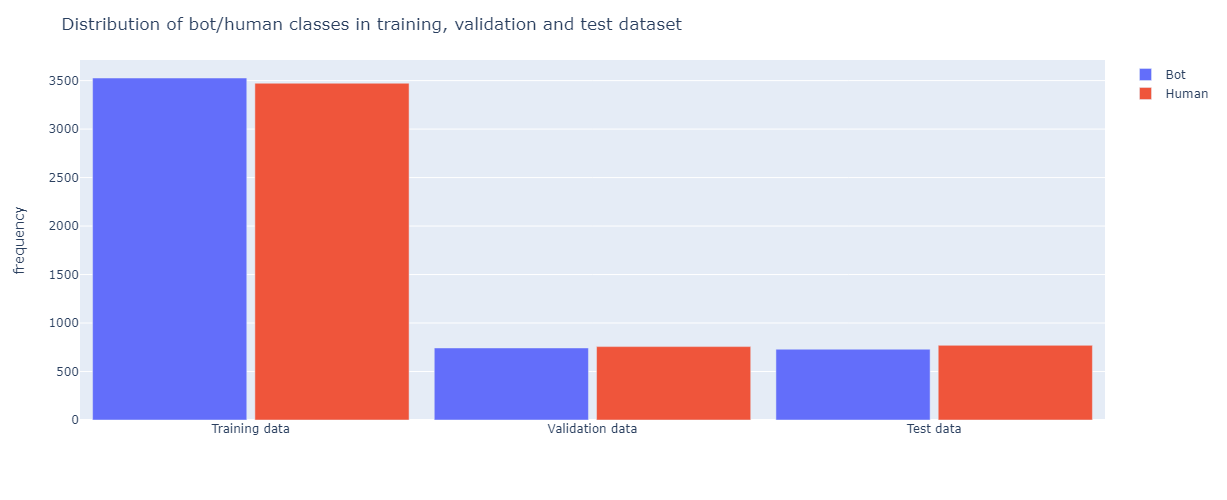

In [47]:
fig = px.bar(sdf, x="Set", y="Freq",
             color="Label", hover_data=['Label'],
             barmode = 'group')
fig.update_layout(
    title_text='Distribution of bot/human classes in training, validation and test dataset',
    xaxis_title_text='', #'subset',
    yaxis_title_text='frequency',
    bargap=0.05,
    bargroupgap=0.05,
    width=700,
    height=500,
    legend={"title":""})
fig.show()

## Distribution of other features in training dataset

### followers_count

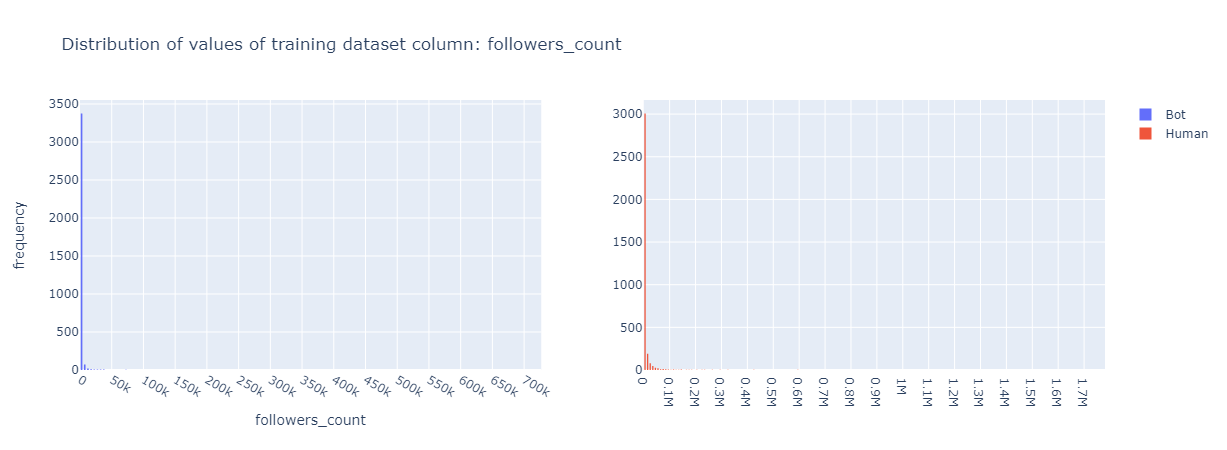

In [48]:
fig = go.Figure()
fig = make_subplots(rows=1, cols=2, specs=[[{'type':'histogram'}, {'type':'histogram'}]])

fig.add_trace(go.Histogram(
    x=train_users_data.loc[train_users_data['label']==1,'followers_count'],
    # histnorm='density',
    nbinsx=200,
    name='Bot'),
row=1, col=1
)
fig.add_trace(go.Histogram(
    x=train_users_data.loc[train_users_data['label']==0,'followers_count'],
    # histnorm='density',
    nbinsx=200,
    name='Human'),
row=1, col=2
)

fig.update_layout(
    title_text='Distribution of values of training dataset column: followers_count',
    xaxis_title_text='followers_count', #'feature',
    yaxis_title_text='frequency',
    bargap=0.5,
    bargroupgap=None, #0.8,
    width=1100,
    height=450,
    legend={"title":""},
    xaxis=dict(showgrid=True,title='followers_count', dtick=50000, range=[0, max(train_users_data.loc[train_users_data['label']==1,'followers_count'])+25000]),
    xaxis2=dict(showgrid=True, dtick=100000, range=[0, max(train_users_data.loc[train_users_data['label']==0,'followers_count'])+50000]),
    yaxis=dict(showgrid=True))

fig.show()

In [49]:
len(train_users_data[(train_users_data['label']==1)])

3527

In [50]:
len(train_users_data[(train_users_data['label']==0)])

3473

In [51]:
from scipy.stats import expon

# Fit an exponential distribution to data
loc_b, scale_b = expon.fit(train_users_data.loc[train_users_data['label']==1]['followers_count'])
loc_h, scale_h = expon.fit(train_users_data.loc[train_users_data['label']==0]['followers_count'])

# Calculate the 99th percentile using the percent-point function (inverse CDF)
percentile_99_bots = expon.ppf(0.99, loc=loc_b, scale=scale_b)
percentile_99_humans = expon.ppf(0.99, loc=loc_h, scale=scale_h)
df_reduced_outliers_followers_count = train_users_data[((train_users_data['label']==1) & (train_users_data['followers_count'] < percentile_99_bots)) | ((train_users_data['label']==0) & (train_users_data['followers_count'] < percentile_99_humans))]
df_filtered_bots = train_users_data[(train_users_data['label']==1) & (train_users_data['followers_count'] < percentile_99_bots)]
df_filtered_humans = train_users_data[(train_users_data['label']==0) & (train_users_data['followers_count'] < percentile_99_humans)]

In [52]:
def df_99_percentile(df, column_name):
    # Fit an exponential distribution to data
    loc_b, scale_b = expon.fit(df.loc[df['label']==1][column_name])
    loc_h, scale_h = expon.fit(df.loc[df['label']==0][column_name])

    # Calculate the 99th percentile using the percent-point function (inverse CDF)
    percentile_99_bots = expon.ppf(0.99, loc=loc_b, scale=scale_b)
    percentile_99_humans = expon.ppf(0.99, loc=loc_h, scale=scale_h)
    return df[((df['label']==1) & (df[column_name] < percentile_99_bots)) | ((df['label']==0) & (df[column_name] < percentile_99_humans))]

#### following_count

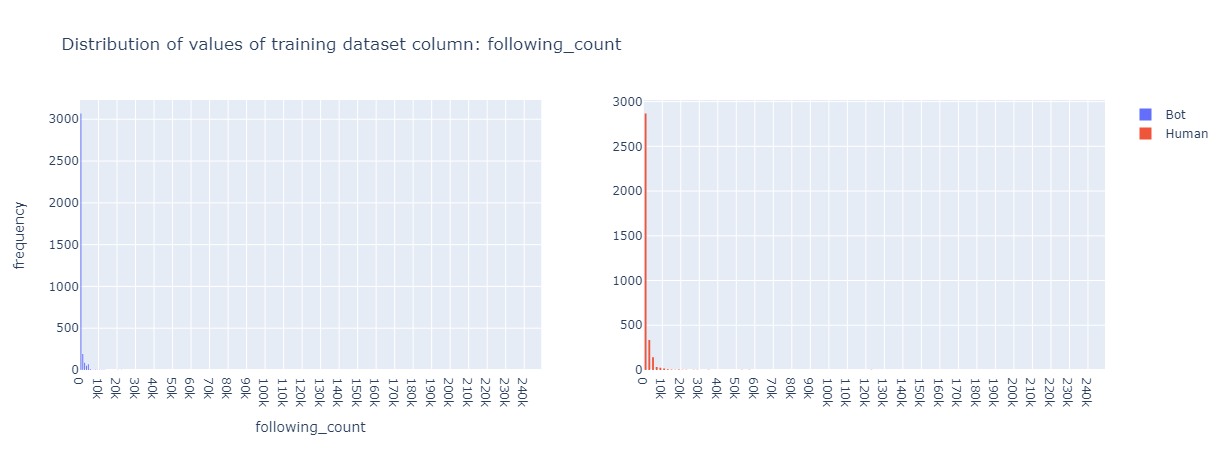

In [53]:
fig = go.Figure()
fig = make_subplots(rows=1, cols=2, specs=[[{'type':'histogram'}, {'type':'histogram'}]])

fig.add_trace(go.Histogram(
    x=train_users_data.loc[train_users_data['label']==1,'following_count'],
    # histnorm='density',
    nbinsx=200,
    name='Bot'),
row=1, col=1
)
fig.add_trace(go.Histogram(
    x=train_users_data.loc[train_users_data['label']==0,'following_count'],
    # histnorm='density',
    nbinsx=200,
    name='Human'),
row=1, col=2
)

fig.update_layout(
    title_text='Distribution of values of training dataset column: following_count',
    xaxis_title_text='following_count', #'feature',
    yaxis_title_text='frequency',
    bargap=0.5,
    bargroupgap=None, #0.8,
    width=1100,
    height=450,
    legend={"title":""},
    xaxis=dict(showgrid=True, dtick=10000, range=[0, max(train_users_data['following_count'])+5000]),
    xaxis2=dict(showgrid=True, dtick=10000, range=[0, max(train_users_data['following_count'])+5000]),
    yaxis=dict(showgrid=True))

fig.show()

#### tweet_count

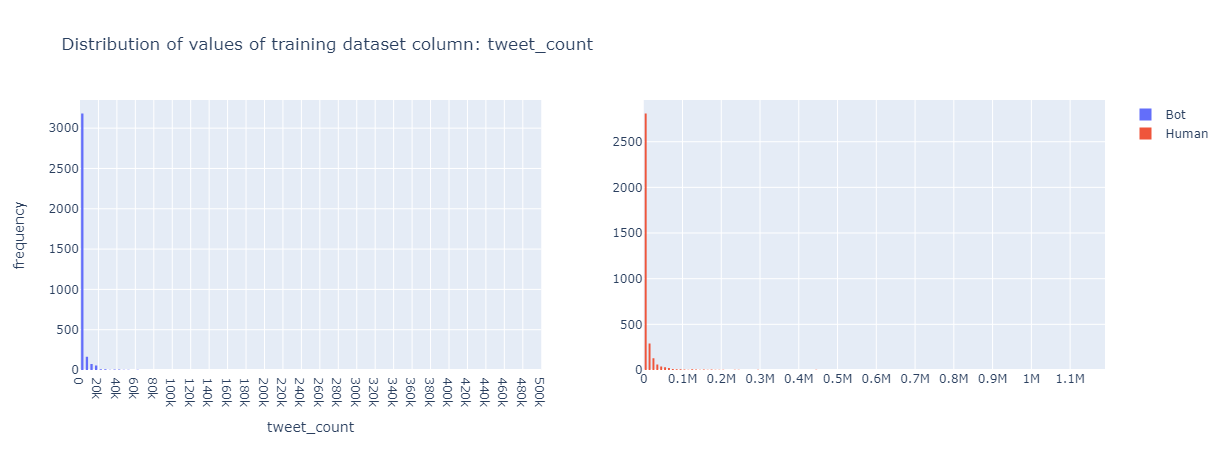

In [54]:
fig = go.Figure()
fig = make_subplots(rows=1, cols=2, specs=[[{'type':'histogram'}, {'type':'histogram'}]])

fig.add_trace(go.Histogram(
    x=train_users_data.loc[train_users_data['label']==1,'tweet_count'],
    # histnorm='density',
    nbinsx=200,
    name='Bot'),
row=1, col=1
)
fig.add_trace(go.Histogram(
    x=train_users_data.loc[train_users_data['label']==0,'tweet_count'],
    # histnorm='density',
    nbinsx=200,
    name='Human'),
row=1, col=2
)

fig.update_layout(
    title_text='Distribution of values of training dataset column: tweet_count',
    xaxis_title_text='tweet_count', #'feature',
    yaxis_title_text='frequency',
    bargap=0.5,
    bargroupgap=None, #0.8,
    width=1100,
    height=450,
    legend={"title":""},
    xaxis=dict(showgrid=True, dtick=20000),
    xaxis2=dict(showgrid=True, dtick=100000),
    yaxis=dict(showgrid=True))

fig.show()

### descr_len

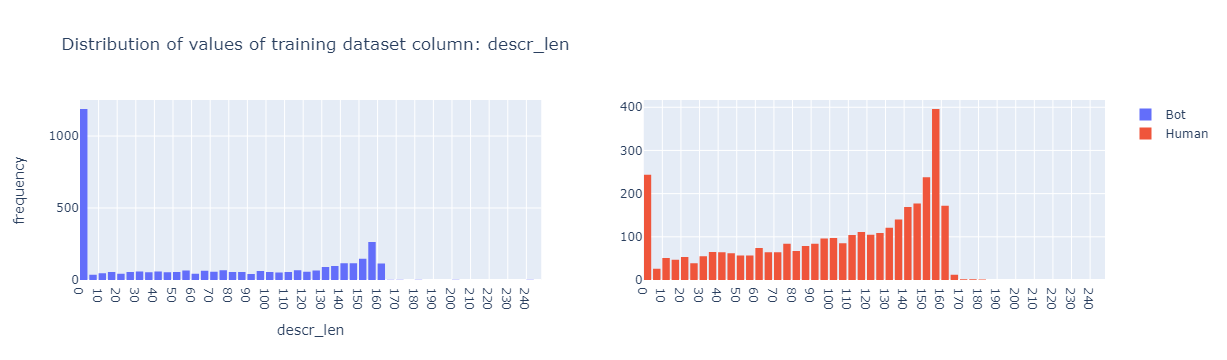

In [55]:
fig = go.Figure()
fig = make_subplots(rows=1, cols=2, specs=[[{'type':'histogram'}, {'type':'histogram'}]])

fig.add_trace(go.Histogram(
    x=train_users_data.loc[train_users_data['label']==1,'descr_len'],
    # histnorm='density',
    # nbinsx=30,
    name='Bot'),
row=1, col=1
)
fig.add_trace(go.Histogram(
    x=train_users_data.loc[train_users_data['label']==0,'descr_len'],
    # histnorm='density',
    # nbinsx=30,
    name='Human'),
row=1, col=2
)

fig.update_layout(
    title_text='Distribution of values of training dataset column: descr_len',
    xaxis_title_text='descr_len', #'feature',
    yaxis_title_text='frequency',
    bargap=0.2,
    bargroupgap=None, #0.8,
    width=1100,
    height=350,
    legend={"title":""},
    xaxis=dict(showgrid=True, dtick=10, range=[0, max(train_users_data['descr_len'])+5]),
    xaxis2=dict(showgrid=True, dtick=10, range=[0, max(train_users_data['descr_len'])+5]),
    yaxis=dict(showgrid=True))

fig.show()

### account_age

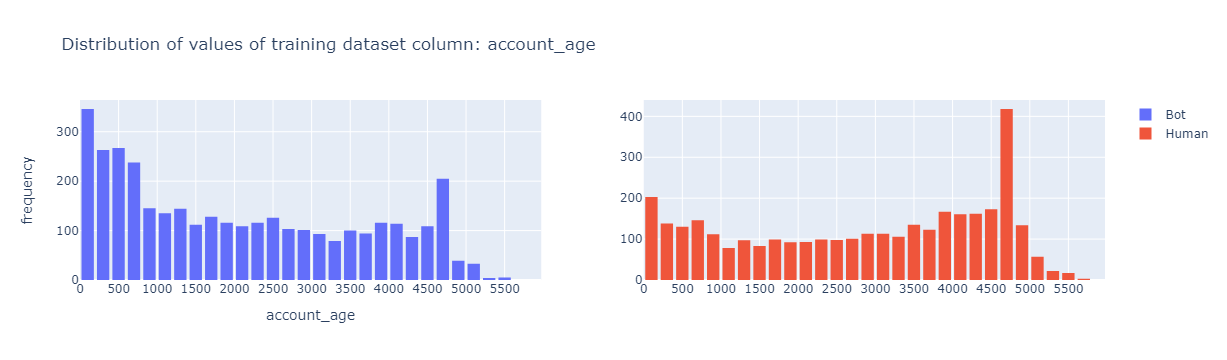

In [56]:
fig = go.Figure()
fig = make_subplots(rows=1, cols=2, specs=[[{'type':'histogram'}, {'type':'histogram'}]])

fig.add_trace(go.Histogram(
    x=train_users_data.loc[train_users_data['label']==1,'account_age'],
    # histnorm='density',
    # nbinsx=30,
    name='Bot'),
row=1, col=1
)
fig.add_trace(go.Histogram(
    x=train_users_data.loc[train_users_data['label']==0,'account_age'],
    # histnorm='density',
    # nbinsx=30,
    name='Human'),
row=1, col=2
)

fig.update_layout(
    title_text='Distribution of values of training dataset column: account_age',
    xaxis_title_text='account_age', #'feature',
    yaxis_title_text='frequency',
    bargap=0.2,
    bargroupgap=None, #0.8,
    width=1100,
    height=350,
    legend={"title":""},
    xaxis=dict(showgrid=True, dtick=500, range=[0, max(train_users_data['account_age'])+250]),
    xaxis2=dict(showgrid=True, dtick=500, range=[0, max(train_users_data['account_age'])+250]),
    yaxis=dict(showgrid=True))

fig.show()

In [57]:
len(train_users_data)

7000

### Filter to have the same number of records for each class - part II

In [58]:
train_users_data = filter_df_for_balanced_classes(train_users_data, bot_label_value=1, human_label_value=0)
val_users_data = filter_df_for_balanced_classes(val_users_data, bot_label_value=1, human_label_value=0)
test_users_data = filter_df_for_balanced_classes(test_users_data, bot_label_value=1, human_label_value=0)

Number of bots:  3473
Number of human users:  3473
Number of bots:  743
Number of human users:  743
Number of bots:  730
Number of human users:  730


#### First drop columns in dataframes where there are same value in whole columns in training dataset

In [59]:
same_data_columns = list(train_users_data.columns[train_users_data.apply(lambda x: x.nunique()) == 1])
same_data_columns

[]

In [60]:
train_users_data = train_users_data.drop(same_data_columns, axis=1)

val_users_data = val_users_data.drop(same_data_columns, axis=1)
test_users_data = test_users_data.drop(same_data_columns, axis=1)

### Standardize data by column range of training set

In [61]:
def standardize_column(df, col_name, mean_training, std_training):
    df_cp = df.copy()
    df_cp[col_name] = (df[col_name] - mean_training) / std_training

    return df_cp

In [62]:
# columns_to_standardize = ['followers_count', 'following_count', 'tweet_count', 'descr_len', 'account_age']
columns_to_standardize = list(train_users_data.columns)
columns_to_standardize.remove('label')
columns_to_standardize.remove('id')

In [63]:
for column_name in columns_to_standardize:
    mean_training = train_users_data[column_name].mean()
    std_training = train_users_data[column_name].std()
    print("mean_training = ", column_name)
    print("mean_training = ", mean_training)
    print("std_training = ", std_training)

    train_users_data = standardize_column(train_users_data, column_name, mean_training, std_training)
    val_users_data = standardize_column(val_users_data, column_name, mean_training, std_training)
    test_users_data = standardize_column(test_users_data, column_name, mean_training, std_training)

## Correlation

In [64]:
sns.set(font_scale=2)

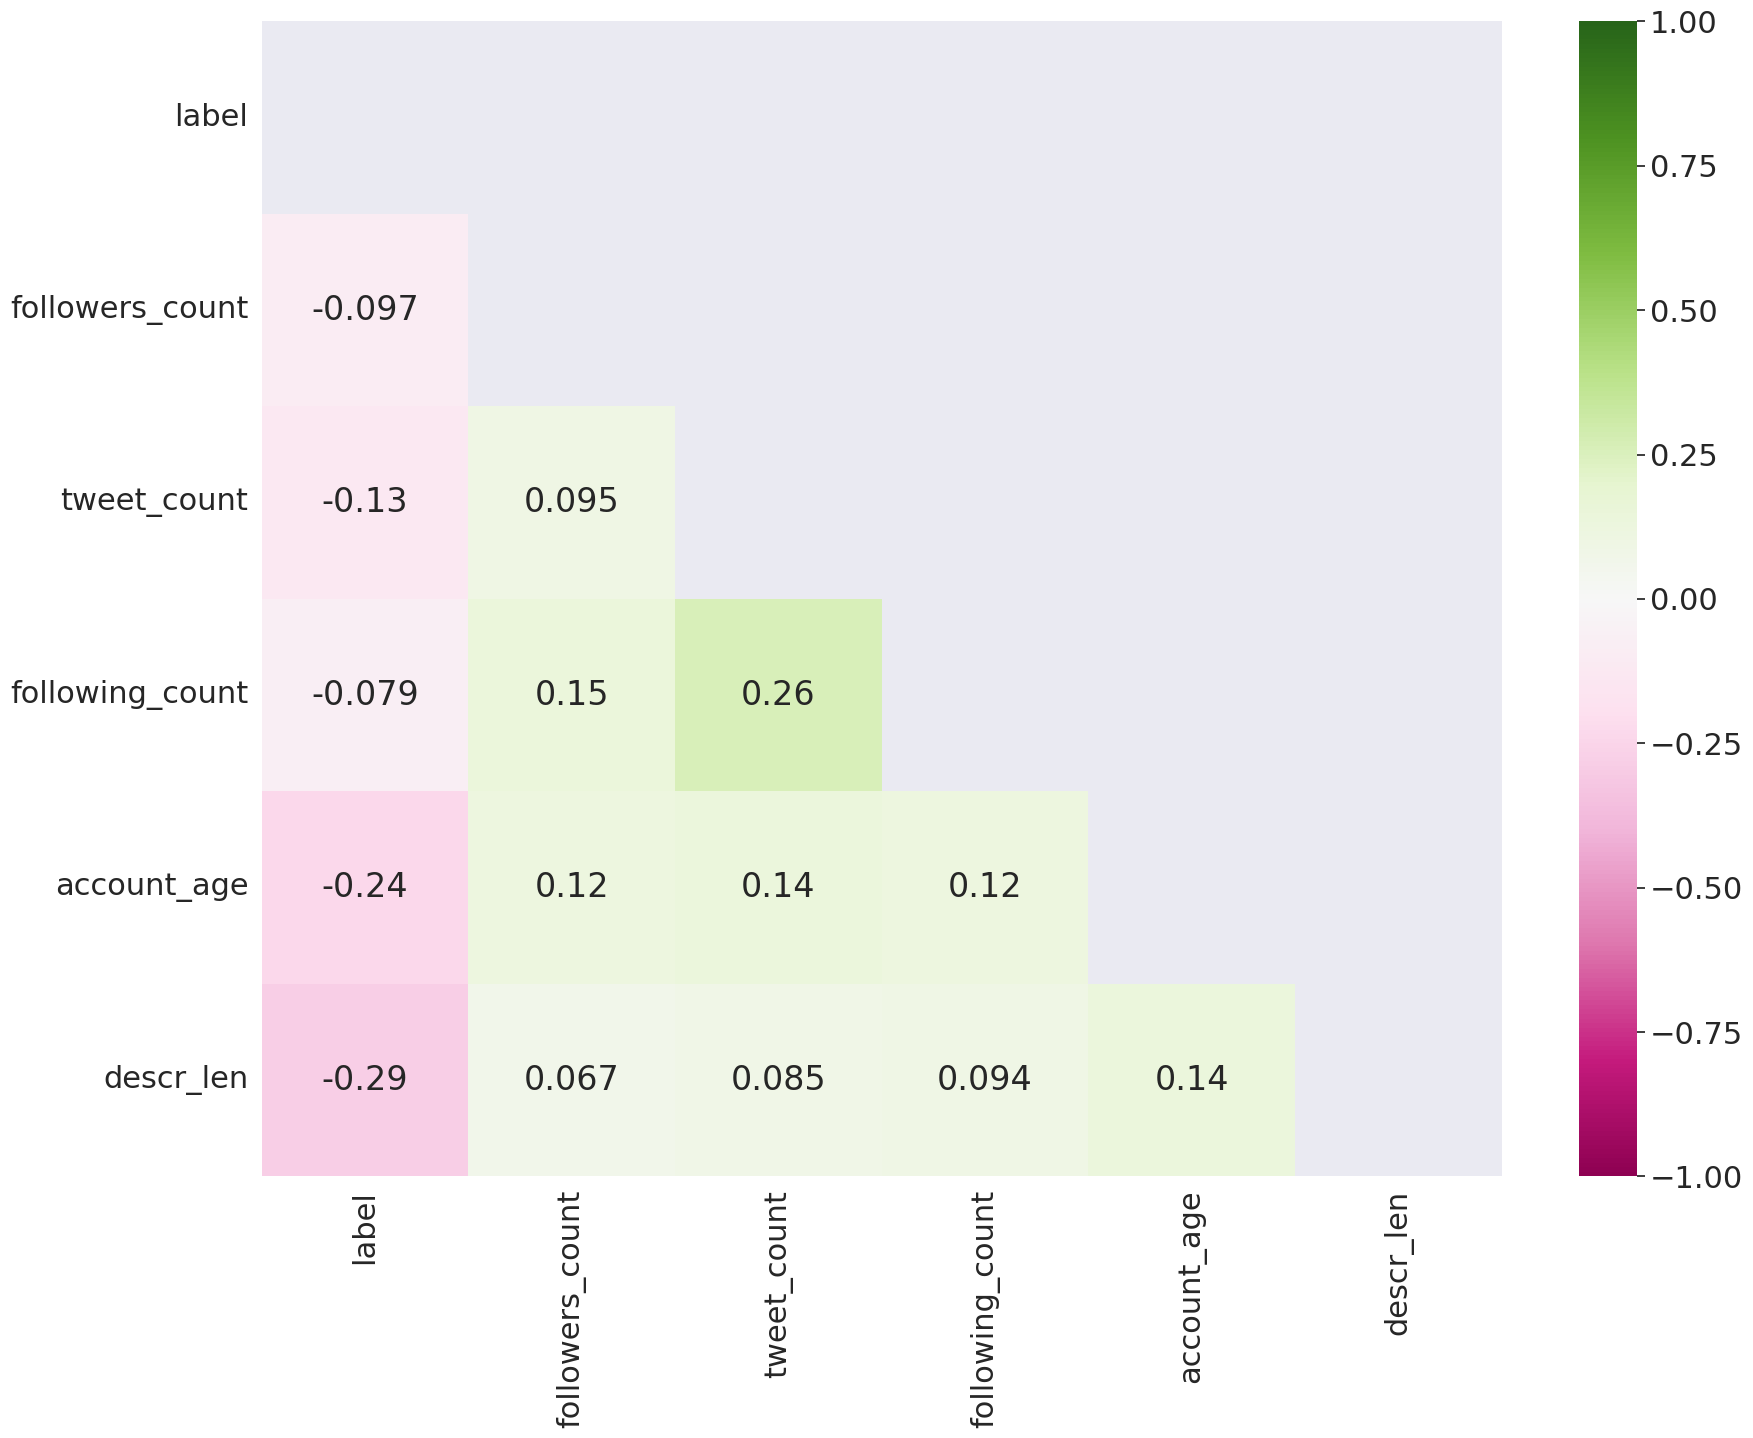

In [65]:
corr_threshold = 0.52
corr = train_users_data.drop(['id'], axis=1).corr()
lower_tri = corr.where(np.tril(np.ones(corr.shape),k=-1).astype(bool)) #creating lower triangular correlation matrix
f = plt.figure(figsize=(20, 15))
sns.heatmap(lower_tri, cmap="PiYG", annot=True, vmin=-1, vmax=1, ax=plt.gca()) #, annot_kws={"fontsize": 16})
high_corr = []
for column in train_users_data:
    if (column != 'id'):
        for col in train_users_data:
            if (col != 'id'):
                if abs(lower_tri[column][col]) > corr_threshold:
                    high_corr.append((column, col, lower_tri[column][col]))
high_corr = sorted(high_corr, key=lambda x: x[2], reverse=True)

In [66]:
sns.set(font_scale=1)

In [67]:
print("Number of columns containing high correlation:", len(set([x[0] for x in high_corr])))
high_corr

Number of columns containing high correlation: 0


[]

In [68]:
# train_users_data = train_users_data.drop(['listed_count'], axis=1)
# val_users_data = val_users_data.drop(['listed_count'], axis=1)
# test_users_data = test_users_data.drop(['listed_count'], axis=1)

# train_users_data = train_users_data.drop(['has_description'], axis=1)
# val_users_data = val_users_data.drop(['has_description'], axis=1)
# test_users_data = test_users_data.drop(['has_description'], axis=1)

In [69]:
train_users_data

label                   id  followers_count  tweet_count  \
6625    0.0  1214018601683836928        -0.128094    -0.192545   
2489    0.0            109927809        -0.078032    -0.044047   
9919    0.0           2325624539        -0.092643    -0.120715   
6964    1.0  1362188147250061315        -0.140643    -0.198103   
3467    0.0  1105810614935531521        -0.133711    -0.059549   
...     ...                  ...              ...          ...   
3325    0.0           1059189764        -0.128705    -0.129968   
1881    0.0            235022253        -0.116065    -0.046150   
4861    0.0           3053537383        -0.140371    -0.198013   
1175    0.0           4348813577        -0.139805    -0.197232   
8447    0.0   912359571947085824         3.903521    -0.173889   

      following_count  account_age  descr_len  
6625        -0.113436    -1.001878   1.043950  
2489         0.038726     1.209547   1.111053  
9919         0.608965     0.315346   1.262037  
6964        -0.196107    -1.250572  -1.422111  
3467        -0.178369    -0.819624   0.993622  
...               ...          ...        ...  
3325         0.053210     0.557335   1.262037  
1881         0.438414     1.001083   1.060726  
4861        -0.189598     0.078234  -0.616867  
1175        -0.155423    -0.090000  -1.422111  
8447        -0.135731    -0.494128   0.909742  

[6946 rows x 7 columns]

------
------

# Tweets data

------

## Loading data

In [70]:
tweets_table_name = "tweets"
BQ_TABLE_TWEETS = dataset_name + "." + tweets_table_name
tweets_table_id = project_id + "." + BQ_TABLE_TWEETS

In [71]:
# comma-separated string of user IDs from users dataframe
users_df0 = pd.DataFrame(users_df1).copy()
users_df0['id'] = users_df0['id'].astype(str)
user_ids = users_df0['id'].to_list()

# # SQL query to select records from the 'tweets' table
SQL_QUERY = f"""SELECT * FROM {BQ_TABLE_TWEETS} WHERE CAST(author_id AS STRING) IN ({str(user_ids)[1:-1]})"""

tweets_df1 = bqclient.query(SQL_QUERY).to_dataframe()

In [72]:
len(tweets_df1)

426163

In [73]:
tweets_df1

id            author_id  created_at  \
0        t871667974888988672             18456141  1496656814   
1       t1451246919590760454             50338306  1634839203   
2       t1464338171211227141             50338306  1637960400   
3       t1486051245441929219             50338306  1643137201   
4       t1449051082244739075            106526969  1634315674   
...                      ...                  ...         ...   
426158  t1494355678781374464  1298362221731274752  1645117132   
426159  t1496455096124772353  1442657001440489480  1645617672   
426160  t1490679777857970179  1468895392699846656  1644240729   
426161  t1490456171022626820  1477407428950036485  1644187417   
426162  t1493306549258829830  1486404323231899652  1644867000   

                                                                                                                                                                                                                                                                                                                         org_text  \
0                                                                                                                                                                                                                          10 things in tech you need to know today | https://t.co/iSQu4CN4rY via @BIUK_Tech #Tech #Morning #News   
1                                                                   Shannon Minter is a groundbreaking transgender civil rights attorney who argued successfully before the U.S. Supreme Court. He serves as the legal director of the National Center for Lesbian Rights (NCLR). https://t.co/UAum4Bu2Ce https://t.co/ZYmY080vj3   
2                                                                                                                                                         For the LGBTQ community, the annual end-of-the-year holiday season traditionally kicks off with costumed Halloween parties at clubs and homes.  https://t.co/NJ4CkorXuy   
3                                                                                                         André Leon Talley, an icon of fashion journalism, has died at the age of 73.\nBest known for his roles at Vogue as creative director and editor-at-large, which spanned from the 1980s to 2013. https://t.co/NQ7gZmfm21   
4                                                                                                       A month after Abbott issued a safety notice describing a defect that could cause some of its #COVID tests to return false positive results, the FDA has upgraded the issue into a Class I recall. https://t.co/OofNGRAVWg   
...                                                                                                                                                                                                                                                                                                                           ...   
426158              Looking for a minimalist logo design? Get your quote- https://t.co/TeykKS5TyJ https://t.co/WFRLSEZe7o #logo #icon #company #minimalist #simple #design #premium #unique #sundayvibes #AskFFT #SundayMorning #Haiti #Pecan #Gaskin #Wilt #Mahomes #Ahmed #Fnatic #Miami #NEWTOT #Grass https://t.co/fHd5dCKGUb   
426159            A little RESPECT goes a LONG WAY! We all want to get it, but we don't always give it. Do you feel that you are getting the respect that you deserve?\n#beginagainandwin #Givetoreceive #motivation #doyourpart #can'tcontrolpeople #itiswhatitis #yourfuture #blackmancan #hometraining https://t.co/xAxrkHgZas   
426160                                                                                       It feels good to Be lost In the right DIRECTION\n#Rentalcars #Cab #self #driving #longdrive #safe #mydriver #\n#newjourney #music #longdrive #cars #drivingschool #\n��https://t.co/xDWpE5Okqh\n��8886399949 https://t.co/KFbKVLGh8

In [74]:
org_tweet_df = pd.DataFrame(tweets_df1).copy()
tweets_df = pd.DataFrame(org_tweet_df).copy()

In [75]:
tweets_df.columns

Index(['id', 'author_id', 'created_at', 'org_text', 'text', 'source',
       'withheld', 'copyright_infringement', 'is_reply', 'geo_tagged',
       'latitude', 'longitude', 'conversation_id', 'reply_settings',
       'retweet_count', 'reply_count', 'like_count', 'quote_count',
       'any_polls_attached', 'any_media_attached', 'possibly_sensitive',
       'has_referenced_tweets', 'media_attached', 'no_cashtags', 'no_mentions',
       'no_user_mentions', 'user_mentions', 'no_urls', 'contains_images',
       'contains_annotations', 'no_hashtags', 'hashtags',
       'context_annotations_domain_id', 'context_annotations_domain_name',
       'context_annotations_entity_id', 'context_annotations_entity_name'],
      dtype='object')

In [76]:
len(tweets_df)

426163

In [77]:
tweets_df

id            author_id  created_at  \
0        t871667974888988672             18456141  1496656814   
1       t1451246919590760454             50338306  1634839203   
2       t1464338171211227141             50338306  1637960400   
3       t1486051245441929219             50338306  1643137201   
4       t1449051082244739075            106526969  1634315674   
...                      ...                  ...         ...   
426158  t1494355678781374464  1298362221731274752  1645117132   
426159  t1496455096124772353  1442657001440489480  1645617672   
426160  t1490679777857970179  1468895392699846656  1644240729   
426161  t1490456171022626820  1477407428950036485  1644187417   
426162  t1493306549258829830  1486404323231899652  1644867000   

                                                                                                                                                                                                                                                                                                                         org_text  \
0                                                                                                                                                                                                                          10 things in tech you need to know today | https://t.co/iSQu4CN4rY via @BIUK_Tech #Tech #Morning #News   
1                                                                   Shannon Minter is a groundbreaking transgender civil rights attorney who argued successfully before the U.S. Supreme Court. He serves as the legal director of the National Center for Lesbian Rights (NCLR). https://t.co/UAum4Bu2Ce https://t.co/ZYmY080vj3   
2                                                                                                                                                         For the LGBTQ community, the annual end-of-the-year holiday season traditionally kicks off with costumed Halloween parties at clubs and homes.  https://t.co/NJ4CkorXuy   
3                                                                                                         André Leon Talley, an icon of fashion journalism, has died at the age of 73.\nBest known for his roles at Vogue as creative director and editor-at-large, which spanned from the 1980s to 2013. https://t.co/NQ7gZmfm21   
4                                                                                                       A month after Abbott issued a safety notice describing a defect that could cause some of its #COVID tests to return false positive results, the FDA has upgraded the issue into a Class I recall. https://t.co/OofNGRAVWg   
...                                                                                                                                                                                                                                                                                                                           ...   
426158              Looking for a minimalist logo design? Get your quote- https://t.co/TeykKS5TyJ https://t.co/WFRLSEZe7o #logo #icon #company #minimalist #simple #design #premium #unique #sundayvibes #AskFFT #SundayMorning #Haiti #Pecan #Gaskin #Wilt #Mahomes #Ahmed #Fnatic #Miami #NEWTOT #Grass https://t.co/fHd5dCKGUb   
426159            A little RESPECT goes a LONG WAY! We all want to get it, but we don't always give it. Do you feel that you are getting the respect that you deserve?\n#beginagainandwin #Givetoreceive #motivation #doyourpart #can'tcontrolpeople #itiswhatitis #yourfuture #blackmancan #hometraining https://t.co/xAxrkHgZas   
426160                                                                                       It feels good to Be lost In the right DIRECTION\n#Rentalcars #Cab #self #driving #longdrive #safe #mydriver #\n#newjourney #music #longdrive #cars #drivingschool #\n��https://t.co/xDWpE5Okqh\n��8886399949 https://t.co/KFbKVLGh8

# Data preparation

### Null and NaN statistics

In [78]:
for col_name in tweets_df:
    count1 = pd.isnull(tweets_df[col_name]).sum()
    print(col_name + ": " + str(count1))

id: 0
author_id: 0
created_at: 0
org_text: 0
text: 0
source: 0
withheld: 0
copyright_infringement: 0
is_reply: 0
geo_tagged: 0
latitude: 422884
longitude: 422884
conversation_id: 0
reply_settings: 420428
retweet_count: 0
reply_count: 0
like_count: 0
quote_count: 0
any_polls_attached: 0
any_media_attached: 0
possibly_sensitive: 0
has_referenced_tweets: 0
media_attached: 0
no_cashtags: 0
no_mentions: 0
no_user_mentions: 0
user_mentions: 0
no_urls: 0
contains_images: 0
contains_annotations: 0
no_hashtags: 0
hashtags: 0
context_annotations_domain_id: 426163
context_annotations_domain_name: 426163
context_annotations_entity_id: 426163
context_annotations_entity_name: 426163


### Drop columns with most NaN values

In [79]:
most_nan_columns = ['context_annotations_domain_id',
                    'context_annotations_domain_name',
                    'context_annotations_entity_id',
                    'context_annotations_entity_name',
                    'latitude',
                    'longitude']
tweets_df = drop_columns(tweets_df, most_nan_columns)

### reply_settings

Twitter documentation for that field mantions that: If the field isn’t specified, it will default to everyone.

In [80]:
set(tweets_df.loc[tweets_df['reply_settings'].notna()]['reply_settings'])

{'everyone', 'following', 'mentionedUsers'}

In [81]:
set(tweets_df['reply_settings'])

{None, 'everyone', 'following', 'mentionedUsers'}

#### Replace not specified value / None with 'everyone'

In [82]:
tweets_df['reply_settings'].fillna('everyone', inplace=True)

## Encoding of non-numeric information which will be used by model

#### Encode boolean columns

In [83]:
boolean_columns  = ['withheld',
                    'copyright_infringement',
                    'is_reply',
                    'geo_tagged',
                    'any_polls_attached',
                    'any_media_attached',
                    'possibly_sensitive',
                    'has_referenced_tweets',
                    'media_attached',
                    'contains_images',
                    'contains_annotations']

In [84]:
# Remap the values of the dataframe
for col_name in boolean_columns:
  tweets_df[col_name] = tweets_df[col_name].map({True:1,False:0})

#### Encode reply_settings categorical column

In [85]:
reply_settings_dict = {'everyone' : 0, 
                       'following' : 1, 
                       'mentionedUsers' : 2}

In [86]:
tweets_df['reply_settings'] = tweets_df['reply_settings'].map(reply_settings_dict)

In [87]:
set(tweets_df['reply_settings'])

{0, 1, 2}

In [88]:
tweets_df

id            author_id  created_at  \
0        t871667974888988672             18456141  1496656814   
1       t1451246919590760454             50338306  1634839203   
2       t1464338171211227141             50338306  1637960400   
3       t1486051245441929219             50338306  1643137201   
4       t1449051082244739075            106526969  1634315674   
...                      ...                  ...         ...   
426158  t1494355678781374464  1298362221731274752  1645117132   
426159  t1496455096124772353  1442657001440489480  1645617672   
426160  t1490679777857970179  1468895392699846656  1644240729   
426161  t1490456171022626820  1477407428950036485  1644187417   
426162  t1493306549258829830  1486404323231899652  1644867000   

                                                                                                                                                                                                                                                                                                                         org_text  \
0                                                                                                                                                                                                                          10 things in tech you need to know today | https://t.co/iSQu4CN4rY via @BIUK_Tech #Tech #Morning #News   
1                                                                   Shannon Minter is a groundbreaking transgender civil rights attorney who argued successfully before the U.S. Supreme Court. He serves as the legal director of the National Center for Lesbian Rights (NCLR). https://t.co/UAum4Bu2Ce https://t.co/ZYmY080vj3   
2                                                                                                                                                         For the LGBTQ community, the annual end-of-the-year holiday season traditionally kicks off with costumed Halloween parties at clubs and homes.  https://t.co/NJ4CkorXuy   
3                                                                                                         André Leon Talley, an icon of fashion journalism, has died at the age of 73.\nBest known for his roles at Vogue as creative director and editor-at-large, which spanned from the 1980s to 2013. https://t.co/NQ7gZmfm21   
4                                                                                                       A month after Abbott issued a safety notice describing a defect that could cause some of its #COVID tests to return false positive results, the FDA has upgraded the issue into a Class I recall. https://t.co/OofNGRAVWg   
...                                                                                                                                                                                                                                                                                                                           ...   
426158              Looking for a minimalist logo design? Get your quote- https://t.co/TeykKS5TyJ https://t.co/WFRLSEZe7o #logo #icon #company #minimalist #simple #design #premium #unique #sundayvibes #AskFFT #SundayMorning #Haiti #Pecan #Gaskin #Wilt #Mahomes #Ahmed #Fnatic #Miami #NEWTOT #Grass https://t.co/fHd5dCKGUb   
426159            A little RESPECT goes a LONG WAY! We all want to get it, but we don't always give it. Do you feel that you are getting the respect that you deserve?\n#beginagainandwin #Givetoreceive #motivation #doyourpart #can'tcontrolpeople #itiswhatitis #yourfuture #blackmancan #hometraining https://t.co/xAxrkHgZas   
426160                                                                                       It feels good to Be lost In the right DIRECTION\n#Rentalcars #Cab #self #driving #longdrive #safe #mydriver #\n#newjourney #music #longdrive #cars #drivingschool #\n��https://t.co/xDWpE5Okqh\n��8886399949 https://t.co/KFbKVLGh8

### Extract some information from dataframe to new columns

#### Tweet length

In [89]:
tweets_df['cleaned_tweet_len'] = tweets_df['text'].apply(len).astype(float)
tweets_df['org_tweet_len'] = tweets_df['org_text'].apply(len).astype(float)

#### Time of the date (in min)

In [90]:
def convert_unixtime_to_datetime(a):
    return datetime.utcfromtimestamp(a)

def get_time_in_minutes(unix_time):
    h = convert_unixtime_to_datetime(unix_time).hour
    m = convert_unixtime_to_datetime(unix_time).minute
    all_minutes = (h * 60) + m
    return all_minutes

In [91]:
tweets_df['time_of_creation'] = tweets_df.apply(lambda x:  get_time_in_minutes(x.created_at), axis=1).astype(float)

#### Remove unnecessery columns

In [92]:
tweets_df = tweets_df.drop(['created_at', 'org_text', 'conversation_id'], axis=1)
# user_mentions, hashtags, source

In [93]:
tweets_df

id            author_id  \
0        t871667974888988672             18456141   
1       t1451246919590760454             50338306   
2       t1464338171211227141             50338306   
3       t1486051245441929219             50338306   
4       t1449051082244739075            106526969   
...                      ...                  ...   
426158  t1494355678781374464  1298362221731274752   
426159  t1496455096124772353  1442657001440489480   
426160  t1490679777857970179  1468895392699846656   
426161  t1490456171022626820  1477407428950036485   
426162  t1493306549258829830  1486404323231899652   

                                                                                                                                                                                                                                                                           text  \
0                                                                                                                                                                                                        things in tech you need to know today | via biuktech tech morning news   
1                                                                       shannon minter is a groundbreaking transgender civil rights attorney who argued successfully before the us supreme court he serves as the legal director of the national center for lesbian rights nclr   
2                                                                                                                                     for the lgbtq community the annual endoftheyear holiday season traditionally kicks off with costumed halloween parties at clubs and homes   
3                                                                                                   andre leon talley an icon of fashion journalism has died at the age of best known for his roles at vogue as creative director and editoratlarge which spanned from the s to   
4                                                                                a month after abbott issued a safety notice describing a defect that could cause some of its covid tests to return false positive results the fda has upgraded the issue into a class i recall   
...                                                                                                                                                                                                                                                                         ...   
426158                                                           looking for a minimalist logo design get your quote logo icon company minimalist simple design premium unique sundayvibes askfft sundaymorning haiti pecan gaskin wilt mahomes ahmed fnatic miami newtot grass   
426159  a little respect goes a long way we all want to get it but we dont always give it do you feel that you are getting the respect that you deserve beginagainandwin givetoreceive motivation doyourpart cantcontrolpeople itiswhatitis yourfuture blackmancan hometraining   
426160                                                                                                                        it feels good to be lost in the right direction rentalcars cab self driving longdrive safe mydriver newjourney music longdrive cars drivingschool   
426161                                                                                                                                                                                                on the class layouts bbckhantechcrunch are we allowed to use classes devs   
426162                                                   practitionerassisted stretches help you move efficiently effortlessly relieve stiffness soreness feel lighter younger stretchmedstudios dynamicstretching techniques therapists flexibilitytraining strength bloodflow   

                 source  withheld  copyright_infringement  is_reply  \
0             Hoo

### Remove some leftover special characters

In [94]:
tweets_df['text'] = tweets_df['text'].str.replace('|', '', regex=False)

## Data split for training, validation and testing of tweets data based on users data split

In [95]:
users_train_set_users_id = train_users_data['id']
users_val_set_users_id = val_users_data['id']
users_test_set_users_id = test_users_data['id']

In [96]:
train_tweets_data = tweets_df[tweets_df['author_id'].isin(users_train_set_users_id)]
val_tweets_data = tweets_df[tweets_df['author_id'].isin(users_val_set_users_id)]
test_tweets_data = tweets_df[tweets_df['author_id'].isin(users_test_set_users_id)]

In [97]:
train_tweets_data1 = pd.DataFrame(train_tweets_data).copy()
val_tweets_data1 = pd.DataFrame(val_tweets_data).copy()
test_tweets_data1 = pd.DataFrame(test_tweets_data).copy()

#### Create backup column for text before processing

In [98]:
train_tweets_data.loc[:, 'text_np'] = train_tweets_data['text']

In [99]:
val_tweets_data.loc[:, 'text_np'] = val_tweets_data['text']

In [100]:
test_tweets_data.loc[:, 'text_np'] = test_tweets_data['text']

# Remove stop words and tokenize tweet text and use word embeddings

In [101]:
# from tensorflow.keras.preprocessing.text import Tokenizer
# from tensorflow.keras.preprocessing.sequence import pad_sequences

In [102]:
import nltk
from nltk.tokenize import word_tokenize
from nltk.corpus import stopwords
nltk.download('stopwords')

[nltk_data] Downloading package stopwords to
[nltk_data]     /home/jupyter/nltk_data...
[nltk_data]   Package stopwords is already up-to-date!


True

In [103]:
# train_tweets_data['text_tk'] = train_tweets_data.apply(lambda row : word_tokenize(row['text']), axis=1)
# val_tweets_data['text_tk'] = train_tweets_data.apply(lambda row : word_tokenize(row['text']), axis=1)
# test_tweets_data['text_tk'] = train_tweets_data.apply(lambda row : word_tokenize(row['text']), axis=1)

In [104]:
train_tweets_data.loc[:, 'text_tk'] = train_tweets_data['text'].apply(lambda text : word_tokenize(text))
val_tweets_data.loc[:, 'text_tk'] = val_tweets_data['text'].apply(lambda text : word_tokenize(text))
test_tweets_data.loc[:, 'text_tk'] = test_tweets_data['text'].apply(lambda text : word_tokenize(text))

### Remove stopwords

In [105]:
stop_words = stopwords.words('english')

In [106]:
train_tweets_data.loc[:, 'text_tk'] = train_tweets_data['text_tk'].apply(lambda words: [word for word in words if word not in stop_words])
val_tweets_data.loc[:, 'text_tk'] = val_tweets_data['text_tk'].apply(lambda words: [word for word in words if word not in stop_words])
test_tweets_data.loc[:, 'text_tk'] = test_tweets_data['text_tk'].apply(lambda words: [word for word in words if word not in stop_words])

#### To not have additional spaces

In [107]:
train_tweets_data.loc[:, 'text'] = train_tweets_data['text_tk'].apply(lambda words : ' '.join(words))
val_tweets_data.loc[:, 'text'] = val_tweets_data['text_tk'].apply(lambda words : ' '.join(words))
test_tweets_data.loc[:, 'text'] = test_tweets_data['text_tk'].apply(lambda words : ' '.join(words))

### Word Embedding

In [108]:
# !wget http://nlp.stanford.edu/data/glove.6B.zip
# !unzip glove.6B.zip

In [109]:
from tensorflow.keras.preprocessing.text import Tokenizer
from tensorflow.keras.preprocessing.sequence import pad_sequences

In [110]:
tokenizer = Tokenizer()
tokenizer.fit_on_texts(train_tweets_data['text'])
word_index = tokenizer.word_index

num_words = len(word_index) + 1  # adding 1 for padding token
embedding_dim = 100              # using GloVe 100-dimensional vectors

### Integer encode text

In [111]:
train_tweets_data.loc[:, 'text_seq'] = train_tweets_data['text'].apply(lambda text:  tokenizer.texts_to_sequences([text])[0])
val_tweets_data.loc[:, 'text_seq'] = val_tweets_data['text'].apply(lambda text: tokenizer.texts_to_sequences([text])[0])
test_tweets_data.loc[:, 'text_seq'] = test_tweets_data['text'].apply(lambda text: tokenizer.texts_to_sequences([text])[0])

### Pad encoded text to a max length 

In [112]:
max_length_train = train_tweets_data['text_seq'].apply(len).max()
max_length_val = val_tweets_data['text_seq'].apply(len).max()
max_length_test = test_tweets_data['text_seq'].apply(len).max()

In [113]:
max_length_train

76

In [114]:
max_length_val

37

In [115]:
max_length_test

36

In [116]:
train_tweets_data['text_seq'].apply(len).mean()

14.39626491888712

In [117]:
val_tweets_data['text_seq'].apply(len).mean()

12.773751671504517

In [118]:
test_tweets_data['text_seq'].apply(len).mean()

12.53067008570079

In [119]:
max_length = 30  # max_length_train

In [120]:
train_tweets_data.loc[:, 'text_seq_ps'] = train_tweets_data['text_seq'].apply(lambda encoded: pad_sequences([encoded], maxlen=max_length, padding='post'))
val_tweets_data.loc[:, 'text_seq_ps'] = val_tweets_data['text_seq'].apply(lambda encoded: pad_sequences([encoded], maxlen=max_length, padding='post'))
test_tweets_data.loc[:, 'text_seq_ps'] = test_tweets_data['text_seq'].apply(lambda encoded: pad_sequences([encoded], maxlen=max_length, padding='post'))

#### Load GloVe embedding

In [121]:
embeddings_index = {}
with open('glove.6B.100d.txt', encoding='utf-8') as f:
    for line in f:
        values = line.split()
        word = values[0]
        coefs = np.asarray(values[1:], dtype='float32')
        embeddings_index[word] = coefs

In [122]:
print('Loaded %s word vectors.' % len(embeddings_index))

Loaded 400000 word vectors.


#### Creating a weight matrix for words

In [123]:
embedding_matrix = np.zeros((num_words, embedding_dim))

for word, i in word_index.items():
    embedding_vector = embeddings_index.get(word)
    if embedding_vector is not None:
        embedding_matrix[i] = embedding_vector

### Drop columns in dataframes where there are same value in whole columns in training dataset

In [124]:
not_simple_numeric_col = ['id', 'author_id', 'text', 'user_mentions', 'hashtags', 'text_np', 'text_tk', 'text_seq', 'text_seq_ps']

In [125]:
same_data_columns3 = list(train_tweets_data.drop(not_simple_numeric_col, axis=1).columns[train_tweets_data.drop(not_simple_numeric_col, axis=1).apply(lambda x: x.nunique()) == 1])
same_data_columns3

['withheld', 'copyright_infringement', 'media_attached', 'contains_images']

In [126]:
train_tweets_data = train_tweets_data.drop(same_data_columns3, axis=1)

val_tweets_data = val_tweets_data.drop(same_data_columns3, axis=1)
test_tweets_data = test_tweets_data.drop(same_data_columns3, axis=1)

### Standardize other tweets data by column range of training set

In [127]:
train_tweets_data.columns

Index(['id', 'author_id', 'text', 'source', 'is_reply', 'geo_tagged',
       'reply_settings', 'retweet_count', 'reply_count', 'like_count',
       'quote_count', 'any_polls_attached', 'any_media_attached',
       'possibly_sensitive', 'has_referenced_tweets', 'no_cashtags',
       'no_mentions', 'no_user_mentions', 'user_mentions', 'no_urls',
       'contains_annotations', 'no_hashtags', 'hashtags', 'cleaned_tweet_len',
       'org_tweet_len', 'time_of_creation', 'text_np', 'text_tk', 'text_seq',
       'text_seq_ps'],
      dtype='object')

In [128]:
def standardize_column(df, col_name, mean_training, std_training):
    df_cp = df.copy()
    df_cp[col_name] = (df[col_name] - mean_training) / std_training

    return df_cp

In [129]:
columns_to_standardize = [#'id', 
                          # 'author_id', 
                          # 'text', 
                          # 'source', 
                          'is_reply', 
                          'geo_tagged',
                          'reply_settings', 
                          'retweet_count', 
                          'reply_count', 
                          'like_count', 
                          'quote_count', 
                          'any_polls_attached', 
                          'any_media_attached', 
                          'possibly_sensitive', 
                          'has_referenced_tweets', 
                          'no_cashtags',
                          'no_mentions',
                          'no_user_mentions',
                          # 'user_mentions',
                          'no_urls',
                          'contains_annotations',
                          'no_hashtags',
                          # 'hashtags',
                          'cleaned_tweet_len',
                          'org_tweet_len',
                          'time_of_creation'
                          # 'text_np',
                          # 'text_tk',
                          # 'text_seq',
                          # 'text_seq_ps'
                         ]
# columns_to_standardize.remove()

##### Data type conversion (to float)

In [130]:
for column_name in columns_to_standardize:
    train_tweets_data[column_name] = train_tweets_data[column_name].astype(float)
    val_tweets_data[column_name] = val_tweets_data[column_name].astype(float)
    test_tweets_data[column_name] = test_tweets_data[column_name].astype(float)

#### Standardize

In [131]:
for column_name in columns_to_standardize:
    mean_training = train_tweets_data[column_name].mean()
    std_training = train_tweets_data[column_name].std()
    print(column_name)
    print("mean_training = ", mean_training)
    print("std_training = ", std_training)
    print()
    
    train_tweets_data = standardize_column(train_tweets_data, column_name, mean_training, std_training)
    val_tweets_data = standardize_column(val_tweets_data, column_name, mean_training, std_training)
    test_tweets_data = standardize_column(test_tweets_data, column_name, mean_training, std_training)

## Correlation of numeric tweets data

In [132]:
sns.set(font_scale=0.7)

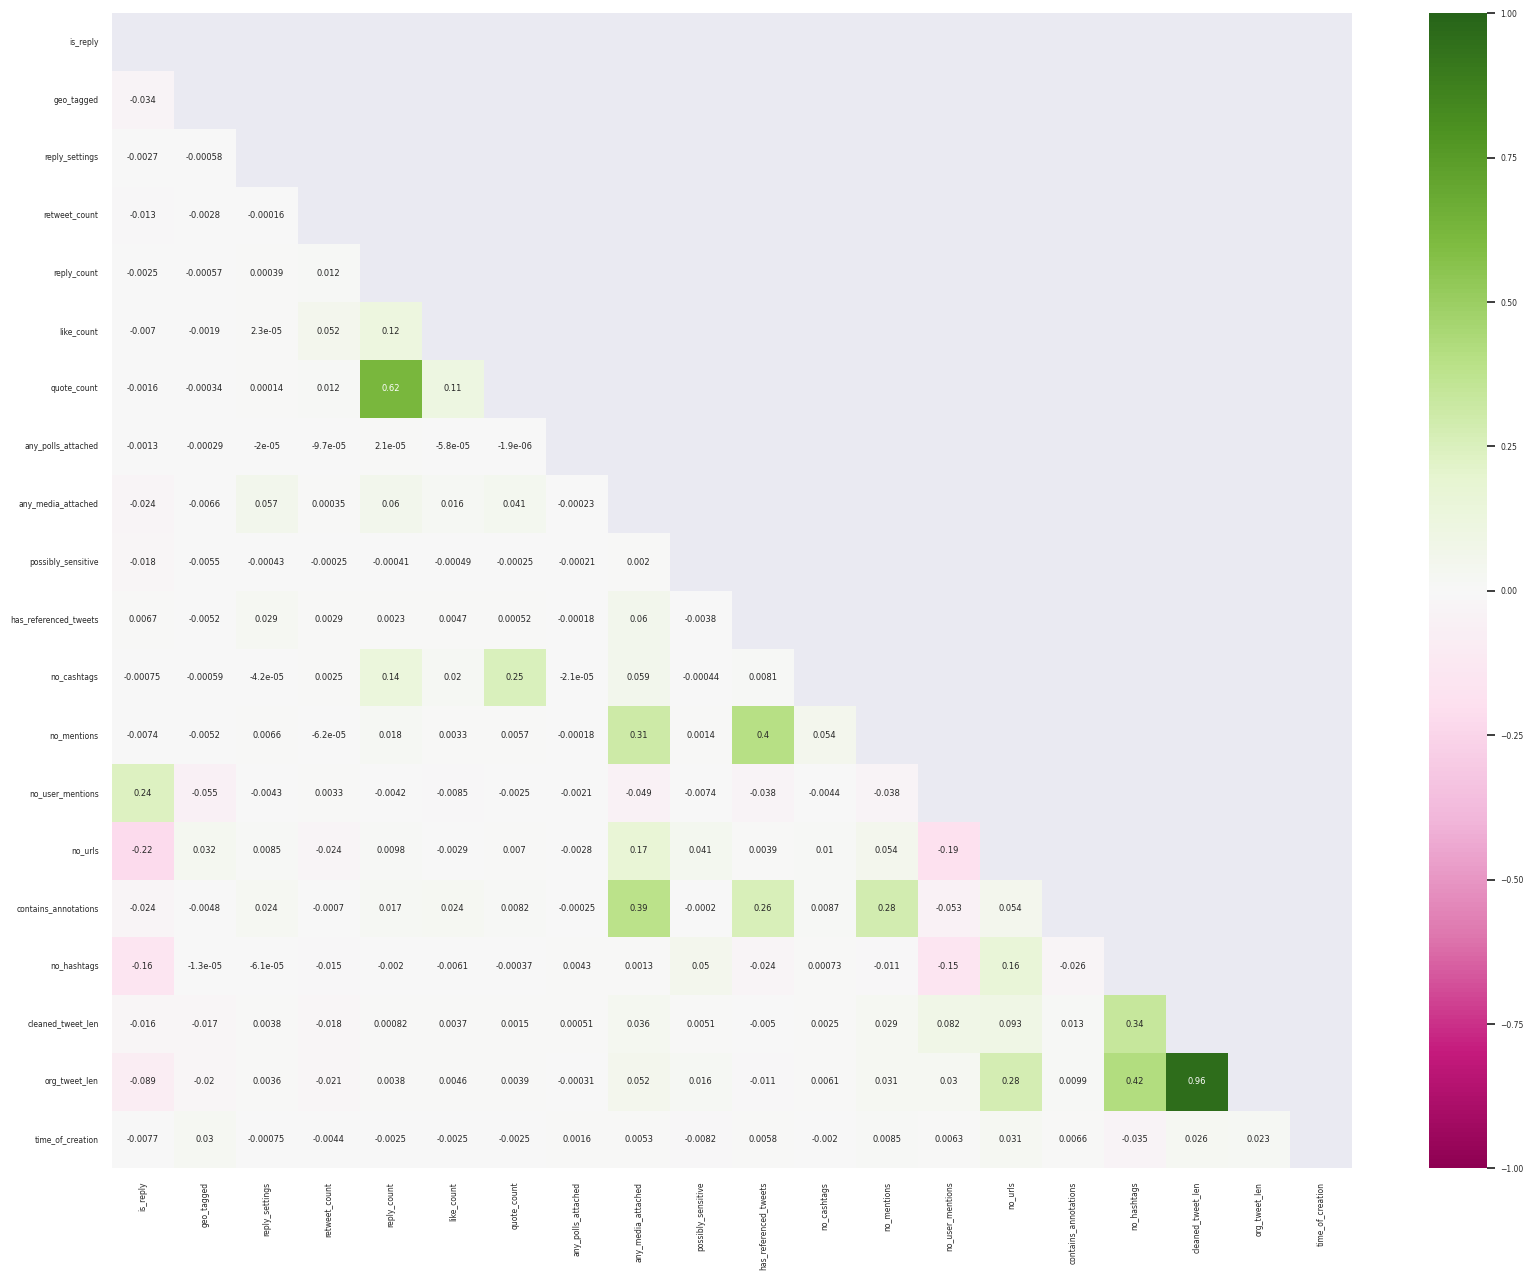

In [133]:
corr_threshold = 0.52
corr = train_tweets_data[columns_to_standardize].corr()
lower_tri = corr.where(np.tril(np.ones(corr.shape),k=-1).astype(bool)) #creating lower triangular correlation matrix
f = plt.figure(figsize=(20, 15))
sns.heatmap(lower_tri, cmap="PiYG", annot=True, vmin=-1, vmax=1, ax=plt.gca()) #, annot_kws={"fontsize": 16})
high_corr3 = []
for column in train_tweets_data[columns_to_standardize]:
   for col in train_tweets_data[columns_to_standardize]:
     if abs(lower_tri[column][col]) > corr_threshold:
         high_corr3.append((column, col, lower_tri[column][col]))
high_corr3 = sorted(high_corr3, key=lambda x: x[2], reverse=True)

In [134]:
sns.set(font_scale=1)

In [135]:
print("Number of columns containing high correlation:", len(set([x[0] for x in high_corr3])))
high_corr3

Number of columns containing high correlation: 2


[('cleaned_tweet_len', 'org_tweet_len', 0.9606590864430019),
 ('reply_count', 'quote_count', 0.6182819260308898)]

In [136]:
train_tweets_data = train_tweets_data.drop(['cleaned_tweet_len', 'quote_count'], axis=1)

In [137]:
val_tweets_data = val_tweets_data.drop(['cleaned_tweet_len', 'quote_count'], axis=1)

In [138]:
test_tweets_data = test_tweets_data.drop(['cleaned_tweet_len', 'quote_count'], axis=1)

In [139]:
all_curr_col = train_tweets_data.columns
simple_num_cols = [c for c in columns_to_standardize if c in all_curr_col]

##  Extend users dataset to match every single tweet in tweets dataset

In [140]:
train_users_data_extended1 = train_tweets_data[['author_id']]
train_users_data_extended = train_users_data_extended1 = pd.merge(train_users_data_extended1, train_users_data, left_on="author_id", right_on="id")
train_users_data_extended = train_users_data_extended.drop(['author_id'], axis=1)

val_users_data_extended1 = val_tweets_data[['author_id']]
val_users_data_extended = val_users_data_extended1 = pd.merge(val_users_data_extended1, val_users_data, left_on="author_id", right_on="id")
val_users_data_extended = val_users_data_extended.drop(['author_id'], axis=1)

test_users_data_extended1 = test_tweets_data[['author_id']]
test_users_data_extended = test_users_data_extended1 = pd.merge(test_users_data_extended1, test_users_data, left_on="author_id", right_on="id")
test_users_data_extended = test_users_data_extended.drop(['author_id'], axis=1)

## Split user data for input and output

In [141]:
train_users_X = train_users_data_extended.drop(['label'], axis=1)
train_users_Y = pd.concat([train_users_data_extended['label']], axis=1)
val_users_X = val_users_data_extended.drop(['label'], axis=1)
val_users_Y = pd.concat([val_users_data_extended['label']], axis=1)
test_users_X = test_users_data_extended.drop(['label'], axis=1)
test_users_Y = pd.concat([test_users_data_extended['label']], axis=1)

In [191]:
print(len(train_users_data_extended.loc[train_users_data_extended['label']==1]))
print(len(train_users_data_extended.loc[train_users_data_extended['label']==0]))
print()
print(len(val_users_data_extended.loc[val_users_data_extended['label']==1]))
print(len(val_users_data_extended.loc[val_users_data_extended['label']==0]))
print()
print(len(test_users_data_extended.loc[test_users_data_extended['label']==1]))
print(len(test_users_data_extended.loc[test_users_data_extended['label']==0]))

123973
176904

25907
35415

24901
34375


## Convert to tensors

In [168]:
train_tweets_text_data_tensor = tf.convert_to_tensor(train_tweets_data['text_seq_ps'].apply(lambda x: x[0]).tolist(), dtype=tf.float32)
train_tweets_add_feat_data_tensor = tf.convert_to_tensor(train_tweets_data[simple_num_cols].values, dtype=tf.float32)
train_users_X_tensor = tf.convert_to_tensor(train_users_X.values, dtype=tf.float32)

In [169]:
val_tweets_text_data_tensor = tf.convert_to_tensor(val_tweets_data['text_seq_ps'].apply(lambda x: x[0]).tolist(), dtype=tf.float32)
val_tweets_add_feat_data_tensor = tf.convert_to_tensor(val_tweets_data[simple_num_cols].values, dtype=tf.float32)
val_users_X_tensor = tf.convert_to_tensor(val_users_X.values, dtype=tf.float32)

test_tweets_text_data_tensor = tf.convert_to_tensor(test_tweets_data['text_seq_ps'].apply(lambda x: x[0]).tolist(), dtype=tf.float32)
test_tweets_add_feat_data_tensor = tf.convert_to_tensor(test_tweets_data[simple_num_cols].values, dtype=tf.float32)
test_users_X_tensor = tf.convert_to_tensor(test_users_X.values, dtype=tf.float32)

------
------

# DNN models

#### Function to load a saved neural network model

In [142]:
from keras.models import load_model

def load_model_from_file(filepath):
  model = load_model(filepath)
  return model

#### Summary of metrics based on real and predicted data by the network

In [143]:
def get_model_metrics(test_Y, out_Y):
  accuracy = accuracy_score(test_Y, out_Y)
  print('Accuracy: {}'.format(accuracy))
  # precision tp / (tp + fp)
  precision = precision_score(test_Y, out_Y, average=None)
  print('Precision: {}'.format(precision))
  # recall: tp / (tp + fn)
  recall = recall_score(test_Y, out_Y)
  print('Recall: {}'.format(recall))
  # f1: 2 tp / (2 tp + fp + fn)
  f1 = f1_score(test_Y, out_Y)
  print('F1 score: %f' % f1)
  # ROC AUC
  auc = roc_auc_score(test_Y, out_Y)
  print('ROC AUC: %f' % auc)
  return (accuracy, precision, recall, f1, auc)

#### Creating a confusion matrix

In [144]:
def create_confusion_matrix(test_Y, out_Y):
    cm = sklearn.metrics.confusion_matrix(test_Y, out_Y)

    group_counts = ["{0:0.0f}".format(value) for value in cm.flatten()]
    group_percentages = ["{0:.2%}".format(value) for value in cm.flatten()/np.sum(cm)]
    labels = [f"{v1}\n\n{v2}" for v1, v2 in zip(group_counts,group_percentages)]
    labels = np.asarray(labels).reshape(2,2)

    plt.figure()
    fig = plt.figure(figsize=(4,4))
    ax = fig.add_subplot(111)

    sns.heatmap(
        cm,
        annot=labels,
        annot_kws={"size": 12},
        fmt='',
        cmap=plt.cm.Blues,
        cbar=False
    )
    ax.set_title("Confusion matrix", fontsize=14)
    ax.set_xticklabels(ax.get_xticklabels(), fontsize=12)
    ax.set_yticklabels(ax.get_yticklabels(), fontsize=12)
    ax.set_ylabel('True', fontsize=12)
    ax.set_xlabel('Predicted', fontsize=12)
    
    fig.show()

## Neural network models 

In [145]:
from tensorflow.keras.layers import Embedding, LSTM, Dense, Dropout, Input, Concatenate, concatenate

In [178]:
# EarlyStopping
def early_stop(metric='val_accuracy', mode = 'max', patience=50):
    return EarlyStopping(monitor='val_accuracy',
                           patience=patience,
                           restore_best_weights=True,
                           mode=mode)
# PlotLosses
def plot_losses():
    return PlotLossesCallback()

# ModelCheckpoint
def checkpoint_callback(model_name):
    return ModelCheckpoint(filepath = models_path + '/' + model_name + '.hdf5',
                            monitor = "val_accuracy",
                            save_best_only = True,
                            # save_weights_only = True,
                            verbose=1)

In [163]:
def train_model(model, model_name, train_X, train_Y, val_X, val_Y, batch_size, epochs):
    model.fit(train_X, train_Y, batch_size=batch_size, epochs=epochs,
                validation_data=(val_X, val_Y),
                callbacks=[plot_losses(),
                           early_stop(),
                           checkpoint_callback(model_name)])
    return model

In [164]:
def prediction_and_metrics(model, test_X, test_Y):
    out_Y_org = model.predict(test_X, verbose=0)
    out_Y = [0 if x < 0.5 else 1 for x in out_Y_org]

    x = range(0, len(test_Y))
    fig = plt.figure(figsize=(18, 4))
    colors = ['blue' if val == 0. else 'red' for val in np.asarray(test_Y)]
    plt.scatter(x, out_Y_org, marker='.', label ='predicted', c=colors)
    plt.plot(x, [0.5] * len(test_Y), c='orange')
    plt.ylim((0,1))

    create_confusion_matrix(test_Y, out_Y)
    get_model_metrics(test_Y, out_Y)

## Model 1.

#### Create model

In [165]:
def create_model_1(num_words, embedding_dim, embedding_matrix, max_sequence_length, trainable=False,
                  add_tweets_feat_size=(18,), add_user_feat_size=(6,), optimizer=tf.keras.optimizers.Adam(learning_rate=0.001)):
    
    # Text input
    text_input = Input(shape=(max_sequence_length,))
    # Embedding layer for text
    embedding_layer = Embedding(num_words, embedding_dim, weights=[embedding_matrix], input_length=max_sequence_length, trainable=trainable)(text_input)
    # LSTM layer
    lstm_layer = LSTM(64)(embedding_layer)
    
    # Additional tweet's features input
    additional_tweet_input = Input(shape=(add_tweets_feat_size,)) 
    # Additional user's features input
    additional_user_input = Input(shape=(add_user_feat_size,)) 
    
    # Concatenate text and additional features
    concatenated = concatenate([lstm_layer, additional_tweet_input, additional_user_input])
    
    dense_layer1 = Dense(128)(concatenated)
    activation_layer1 = Activation('relu')(dense_layer1)
    dropout_layer1 = Dropout(0.5)(dense_layer1)
    dense_layer2 = Dense(64)(dropout_layer1)
    activation_layer2 = Activation('relu')(dense_layer2)
    output_layer = Dense(1, activation='sigmoid')(activation_layer2)
    
    model = Model(inputs=[text_input, additional_tweet_input, additional_user_input], outputs=output_layer)
    
    model.compile(optimizer=optimizer, loss=keras.losses.BinaryCrossentropy(), metrics=['accuracy'])

    return model

### batch_size=200, epochs=10

#### Create and train model

In [167]:
model_name = 'model_users_and_tweets_data_based_10000_1_v1_batch_size_200_user_data_and_single_tweet_glove'
tweets_numeric_subset_size = train_tweets_data[simple_num_cols].shape[1]
users_set_size = train_users_X.shape[1]

model1 = create_model_1(num_words=num_words, embedding_dim=embedding_dim, 
                       embedding_matrix=embedding_matrix, max_sequence_length=max_length, 
                       trainable=False, 
                       add_tweets_feat_size=tweets_numeric_subset_size, #dense_layer1=64, 
                       add_user_feat_size=users_set_size,
                       optimizer=tf.keras.optimizers.Adam(learning_rate=0.001))


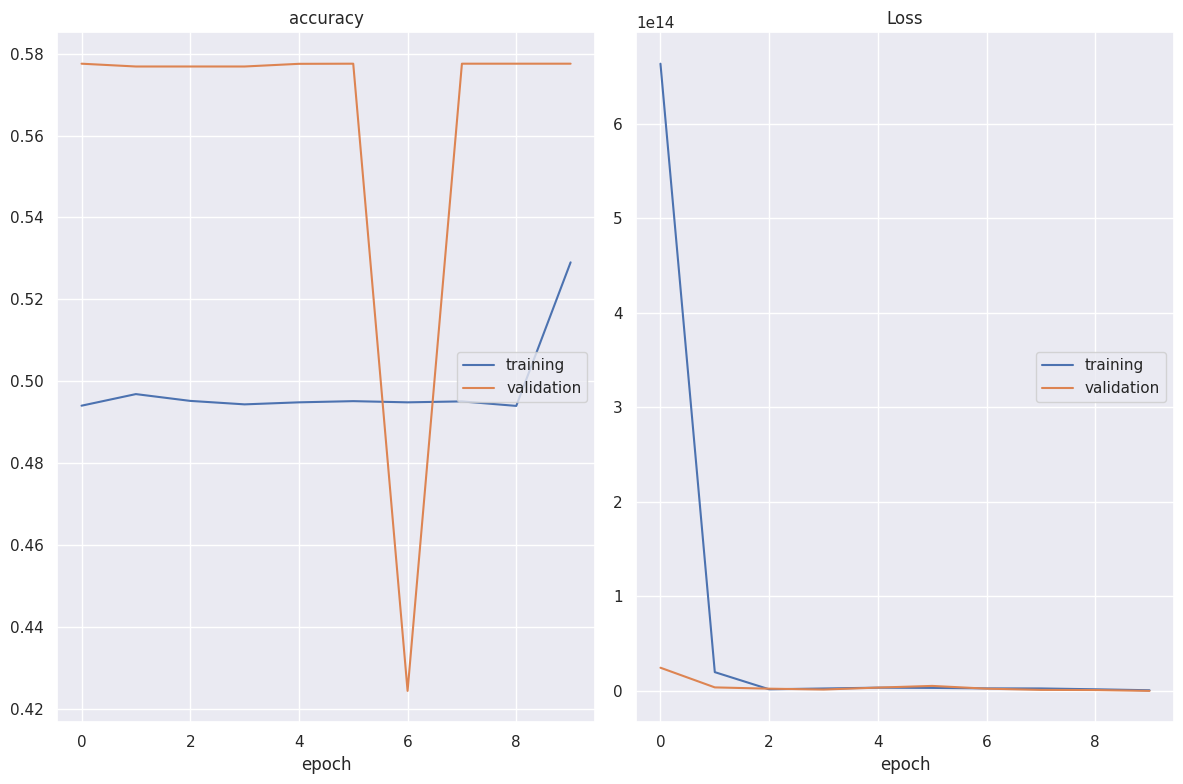

accuracy
	training         	 (min:    0.494, max:    0.529, cur:    0.529)
	validation       	 (min:    0.424, max:    0.578, cur:    0.578)
Loss
	training         	 (min: 668079685632.000, max: 663776659505152.000, cur: 668079685632.000)
	validation       	 (min:    1.806, max: 24514698149888.000, cur:    1.806)

Epoch 10: val_accuracy did not improve from 0.57753
1505/1505 [==============================] - 86s 57ms/step - loss: 668079685632.0000 - accuracy: 0.5290 - val_loss: 1.8058 - val_accuracy: 0.5775


In [170]:
model1 =  train_model(model1, 
                      model_name, 
                      train_X=[train_tweets_text_data_tensor, train_tweets_add_feat_data_tensor, train_users_X_tensor], 
                      train_Y=train_users_Y, 
                      val_X=[val_tweets_text_data_tensor, val_tweets_add_feat_data_tensor, val_users_X_tensor], 
                      val_Y=val_users_Y, 
                      batch_size=200, 
                      epochs=10)

#### Prediction and results

Accuracy: 0.579914299210473
Precision: [0.5799143 0.       ]
Recall: 0.0


/opt/conda/lib/python3.7/site-packages/sklearn/metrics/_classification.py:1318: UndefinedMetricWarning:

Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.



F1 score: 0.000000
ROC AUC: 0.500000


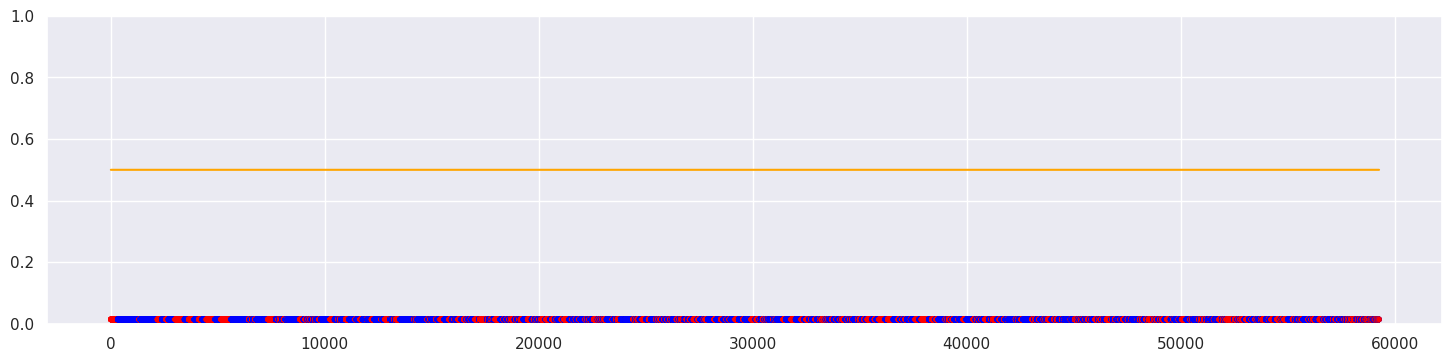

<Figure size 640x480 with 0 Axes>

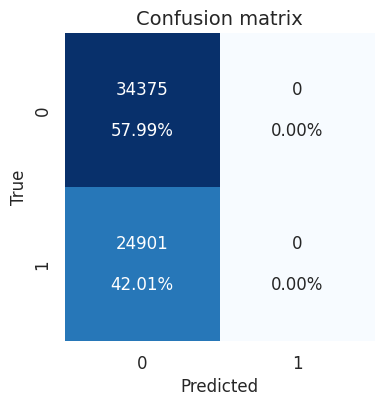

In [175]:
prediction_and_metrics(model1, [test_tweets_text_data_tensor, test_tweets_add_feat_data_tensor, test_users_X_tensor], test_users_Y)

## Model 2.

#### Create and train model

In [172]:
def create_model_2(num_words, embedding_dim, embedding_matrix, max_sequence_length, trainable=False,
                  add_tweets_feat_size=(18,), add_user_feat_size=(6,), optimizer=tf.keras.optimizers.Adam(learning_rate=0.001)):
    
    # # Text input
    # text_input = Input(shape=(max_sequence_length,))
    # # Embedding layer for text
    # embedding_layer = Embedding(num_words, embedding_dim, weights=[embedding_matrix], input_length=max_sequence_length, trainable=trainable)(text_input)
    # # LSTM layer
    # lstm_layer = LSTM(64)(embedding_layer)
    
    # Additional tweet's features input
    additional_tweet_input = Input(shape=(add_tweets_feat_size,)) 
    # Additional user's features input
    additional_user_input = Input(shape=(add_user_feat_size,)) 
    
    # Concatenate text and additional features
    # concatenated = concatenate([lstm_layer, additional_tweet_input, additional_user_input])
    concatenated = concatenate([additional_tweet_input, additional_user_input])
    
    dense_layer1 = Dense(128)(concatenated)
    activation_layer1 = Activation('relu')(dense_layer1)
    dropout_layer1 = Dropout(0.5)(dense_layer1)
    dense_layer2 = Dense(64)(dropout_layer1)
    activation_layer2 = Activation('relu')(dense_layer2)
    output_layer = Dense(1, activation='sigmoid')(activation_layer2)
    
    # model = Model(inputs=[text_input, additional_tweet_input, additional_user_input], outputs=output_layer)
    model = Model(inputs=[additional_tweet_input, additional_user_input], outputs=output_layer)
    
    model.compile(optimizer=optimizer, loss=keras.losses.BinaryCrossentropy(), metrics=['accuracy'])

    return model

In [173]:
model_name = 'model_users_and_tweets_data_based_10000_2_v1_batch_size_200_user_data_and_single_tweet_glove'
tweets_numeric_subset_size = train_tweets_data[simple_num_cols].shape[1]
users_set_size = train_users_X.shape[1]

model2 = create_model_2(num_words=num_words, embedding_dim=embedding_dim, 
                       embedding_matrix=embedding_matrix, max_sequence_length=max_length, 
                       trainable=False, 
                       add_tweets_feat_size=tweets_numeric_subset_size, #dense_layer1=64, 
                       add_user_feat_size=users_set_size,
                       optimizer=tf.keras.optimizers.Adam(learning_rate=0.001))


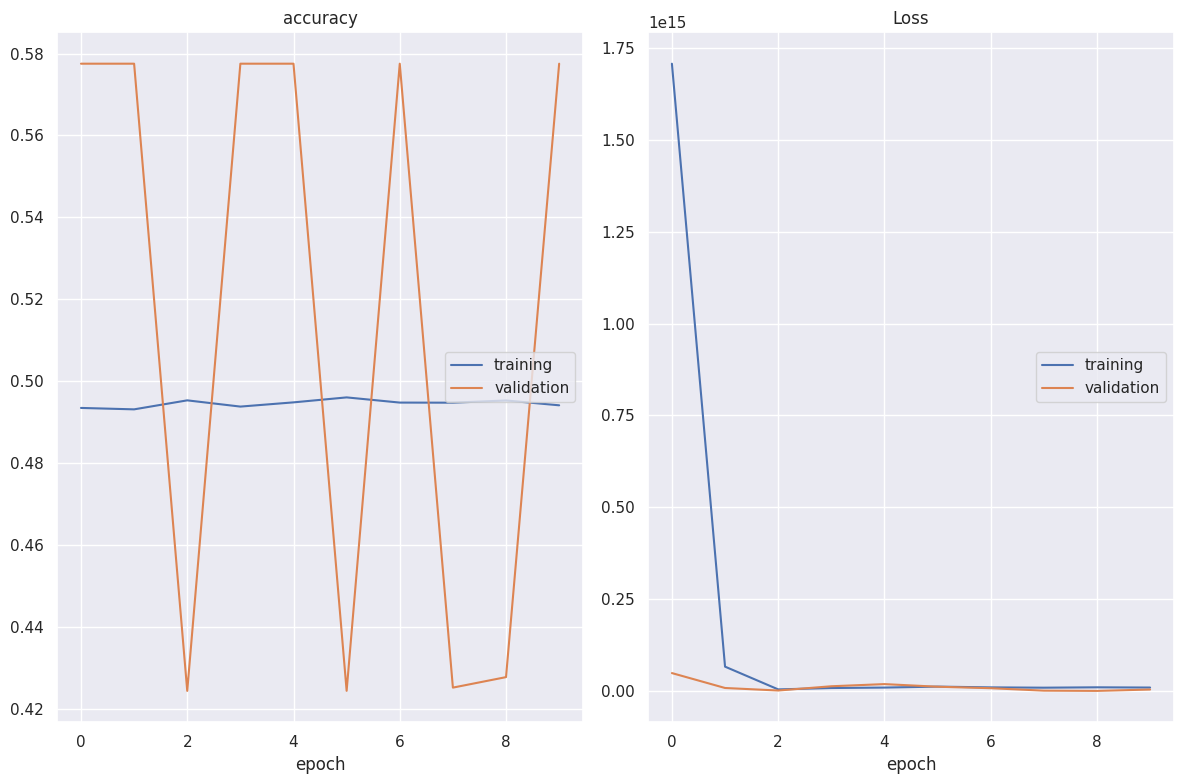

accuracy
	training         	 (min:    0.493, max:    0.496, cur:    0.494)
	validation       	 (min:    0.424, max:    0.578, cur:    0.578)
Loss
	training         	 (min: 4282200358912.000, max: 1707208563752960.000, cur: 9309275553792.000)
	validation       	 (min: 215625089024.000, max: 48692912455680.000, cur: 3921953685504.000)

Epoch 10: val_accuracy did not improve from 0.57753
1505/1505 [==============================] - 7s 5ms/step - loss: 9309275553792.0000 - accuracy: 0.4941 - val_loss: 3921953685504.0000 - val_accuracy: 0.5775


In [174]:
model2 =  train_model(model2, 
                      model_name, 
                      train_X=[train_tweets_add_feat_data_tensor, train_users_X_tensor], 
                      train_Y=train_users_Y, 
                      val_X=[val_tweets_add_feat_data_tensor, val_users_X_tensor], 
                      val_Y=val_users_Y, 
                      batch_size=200, 
                      epochs=10)

#### Prediction and results

Accuracy: 0.579914299210473
Precision: [0.5799143 0.       ]
Recall: 0.0


/opt/conda/lib/python3.7/site-packages/sklearn/metrics/_classification.py:1318: UndefinedMetricWarning:

Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.



F1 score: 0.000000
ROC AUC: 0.500000


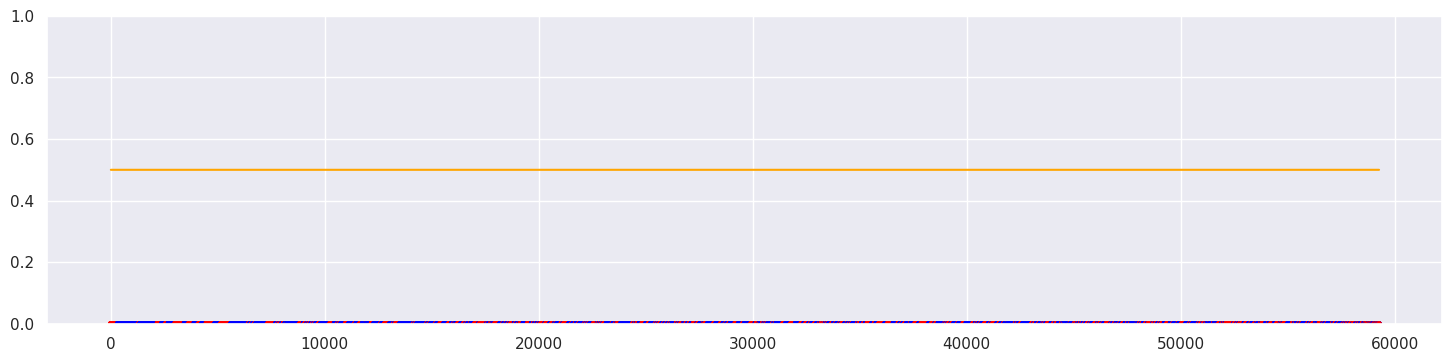

<Figure size 640x480 with 0 Axes>

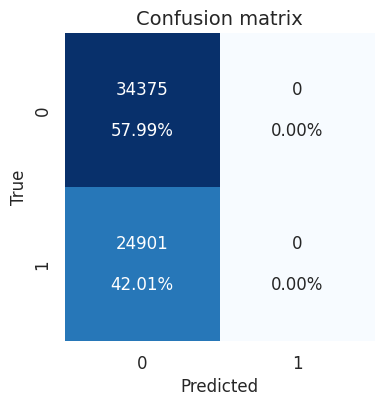

In [180]:
# prediction_and_metrics(model2, [test_tweets_text_data_tensor, test_tweets_add_feat_data_tensor, test_users_X_tensor], test_users_Y)
prediction_and_metrics(model2, [test_tweets_add_feat_data_tensor, test_users_X_tensor], test_users_Y)

## Model 3.

#### Create and train model

In [193]:
def create_model_3(num_words, embedding_dim, embedding_matrix, max_sequence_length, trainable=False,
                  add_tweets_feat_size=(18,), add_user_feat_size=(6,), optimizer=tf.keras.optimizers.Adam(learning_rate=0.001)):
    
    # # Text input
    # text_input = Input(shape=(max_sequence_length,))
    # # Embedding layer for text
    # embedding_layer = Embedding(num_words, embedding_dim, weights=[embedding_matrix], input_length=max_sequence_length, trainable=trainable)(text_input)
    # # LSTM layer
    # lstm_layer = LSTM(64)(embedding_layer)
    
    # Additional tweet's features input
    additional_tweet_input = Input(shape=(add_tweets_feat_size,)) 
    # Additional user's features input
    additional_user_input = Input(shape=(add_user_feat_size,)) 
    
    # Concatenate text and additional features
    # concatenated = concatenate([lstm_layer, additional_tweet_input, additional_user_input])
    concatenated = concatenate([additional_tweet_input, additional_user_input])
    
    dense_layer1 = Dense(64)(concatenated)
    activation_layer1 = Activation('relu')(dense_layer1)
    dropout_layer1 = Dropout(0.1)(dense_layer1)
    dense_layer2 = Dense(64)(dropout_layer1)
    activation_layer2 = Activation('relu')(dense_layer2)
    output_layer = Dense(1, activation='sigmoid')(activation_layer2)
    
    # model = Model(inputs=[text_input, additional_tweet_input, additional_user_input], outputs=output_layer)
    model = Model(inputs=[additional_tweet_input, additional_user_input], outputs=output_layer)
    
    model.compile(optimizer=optimizer, loss=keras.losses.BinaryCrossentropy(), metrics=['accuracy'])

    return model

In [194]:
model_name = 'model_users_and_tweets_data_based_10000_3_v1_batch_size_200_user_data_and_single_tweet_glove'
tweets_numeric_subset_size = train_tweets_data[simple_num_cols].shape[1]
users_set_size = train_users_X.shape[1]

model3 = create_model_3(num_words=num_words, embedding_dim=embedding_dim, 
                       embedding_matrix=embedding_matrix, max_sequence_length=max_length, 
                       trainable=False, 
                       add_tweets_feat_size=tweets_numeric_subset_size, #dense_layer1=64, 
                       add_user_feat_size=users_set_size,
                       optimizer=tf.keras.optimizers.Adam(learning_rate=0.001))


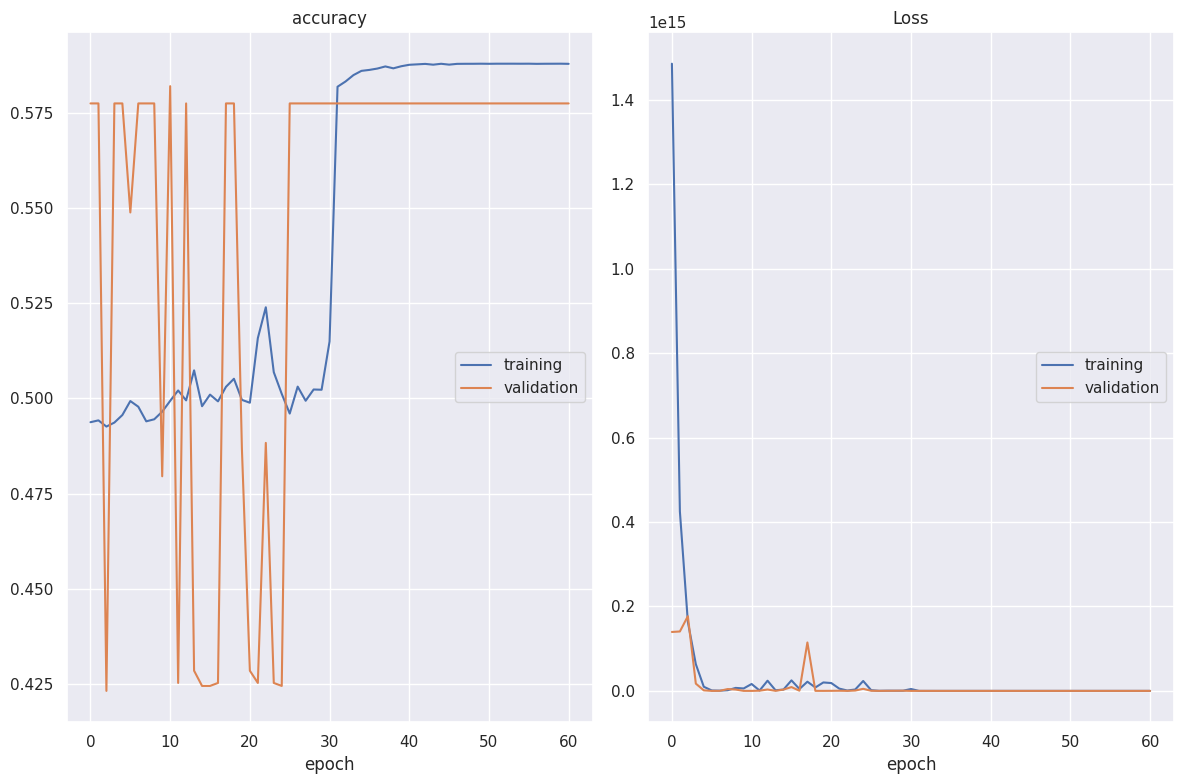

accuracy
	training         	 (min:    0.493, max:    0.588, cur:    0.588)
	validation       	 (min:    0.423, max:    0.582, cur:    0.578)
Loss
	training         	 (min:    0.678, max: 1485692135800832.000, cur: 6864716288.000)
	validation       	 (min:    0.681, max: 176904703311872.000, cur:    0.681)

Epoch 61: val_accuracy did not improve from 0.58206
588/588 [==============================] - 3s 5ms/step - loss: 6864716288.0000 - accuracy: 0.5879 - val_loss: 0.6814 - val_accuracy: 0.5775


In [195]:
model3 =  train_model(model3, 
                      model_name, 
                      train_X=[train_tweets_add_feat_data_tensor, train_users_X_tensor], 
                      train_Y=train_users_Y, 
                      val_X=[val_tweets_add_feat_data_tensor, val_users_X_tensor], 
                      val_Y=val_users_Y, 
                      batch_size=512, 
                      epochs=100)

#### Prediction and results

Accuracy: 0.5653384168972265
Precision: [0.72821247 0.48931011]
Recall: 0.794104654431549
F1 score: 0.605515
ROC AUC: 0.596863


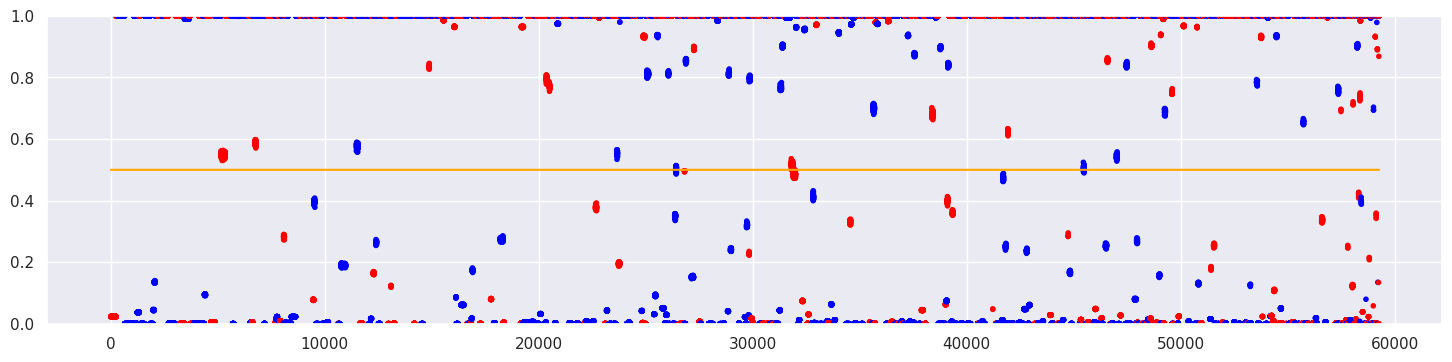

<Figure size 640x480 with 0 Axes>

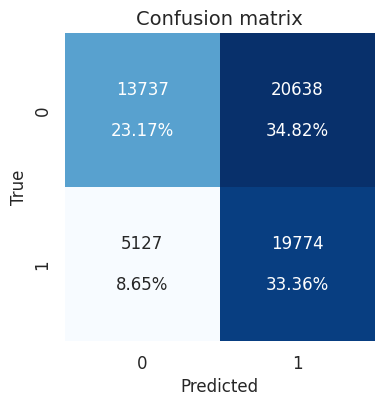

In [196]:
# prediction_and_metrics(model2, [test_tweets_text_data_tensor, test_tweets_add_feat_data_tensor, test_users_X_tensor], test_users_Y)
prediction_and_metrics(model3, [test_tweets_add_feat_data_tensor, test_users_X_tensor], test_users_Y)

## Model 4.

In [202]:
# EarlyStopping
def early_stop(metric='val_accuracy', mode = 'max', patience=200):
    return EarlyStopping(monitor='val_accuracy',
                           patience=patience,
                           restore_best_weights=True,
                           mode=mode)
# PlotLosses
def plot_losses():
    return PlotLossesCallback()

# ModelCheckpoint
def checkpoint_callback(model_name):
    return ModelCheckpoint(filepath = models_path + '/' + model_name + '.hdf5',
                            monitor = "val_accuracy",
                            save_best_only = True,
                            # save_weights_only = True,
                            verbose=1)

In [203]:
def train_model(model, model_name, train_X, train_Y, val_X, val_Y, batch_size, epochs):
    model.fit(train_X, train_Y, batch_size=batch_size, epochs=epochs,
                validation_data=(val_X, val_Y),
                callbacks=[plot_losses(),
                           early_stop(),
                           checkpoint_callback(model_name)])
    return model

#### Create and train model

In [204]:
def create_model_4(num_words, embedding_dim, embedding_matrix, max_sequence_length, trainable=False,
                  add_tweets_feat_size=(18,), add_user_feat_size=(6,), optimizer=tf.keras.optimizers.Adam(learning_rate=0.001)):
    
    # # Text input
    # text_input = Input(shape=(max_sequence_length,))
    # # Embedding layer for text
    # embedding_layer = Embedding(num_words, embedding_dim, weights=[embedding_matrix], input_length=max_sequence_length, trainable=trainable)(text_input)
    # # LSTM layer
    # lstm_layer = LSTM(64)(embedding_layer)
    
    # Additional tweet's features input
    additional_tweet_input = Input(shape=(add_tweets_feat_size,)) 
    # Additional user's features input
    additional_user_input = Input(shape=(add_user_feat_size,)) 
    
    # Concatenate text and additional features
    # concatenated = concatenate([lstm_layer, additional_tweet_input, additional_user_input])
    concatenated = concatenate([additional_tweet_input, additional_user_input])
    
    dense_layer1 = Dense(64)(concatenated)
    activation_layer1 = Activation('relu')(dense_layer1)
    dropout_layer1 = Dropout(0.1)(dense_layer1)
    dense_layer2 = Dense(32)(dropout_layer1)
    activation_layer2 = Activation('relu')(dense_layer2)
    output_layer = Dense(1, activation='sigmoid')(activation_layer2)
    
    # model = Model(inputs=[text_input, additional_tweet_input, additional_user_input], outputs=output_layer)
    model = Model(inputs=[additional_tweet_input, additional_user_input], outputs=output_layer)
    
    model.compile(optimizer=optimizer, loss=keras.losses.BinaryCrossentropy(), metrics=['accuracy'])

    return model

In [205]:
model_name = 'model_users_and_tweets_data_based_10000_4_v1_batch_size_200_user_data_and_single_tweet_glove'
tweets_numeric_subset_size = train_tweets_data[simple_num_cols].shape[1]
users_set_size = train_users_X.shape[1]

model4 = create_model_4(num_words=num_words, embedding_dim=embedding_dim, 
                       embedding_matrix=embedding_matrix, max_sequence_length=max_length, 
                       trainable=False, 
                       add_tweets_feat_size=tweets_numeric_subset_size, #dense_layer1=64, 
                       add_user_feat_size=users_set_size,
                       optimizer=tf.keras.optimizers.Adam(learning_rate=0.001))


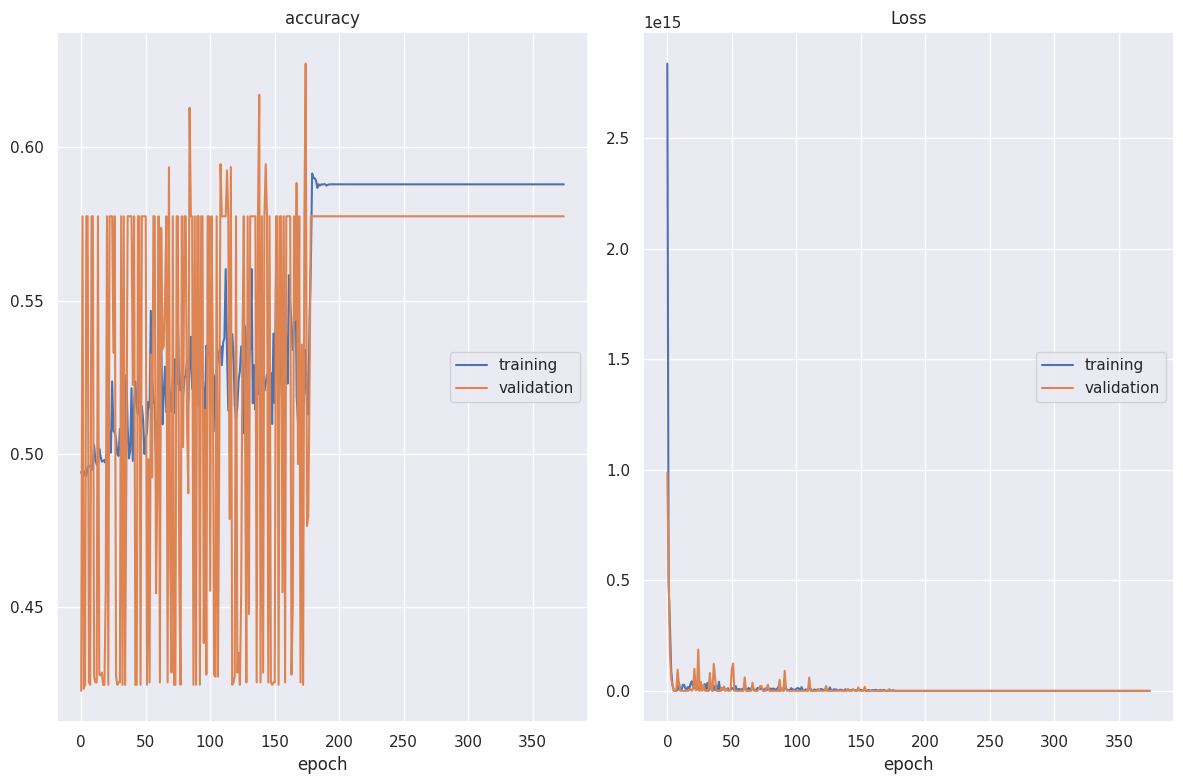

accuracy
	training         	 (min:    0.493, max:    0.591, cur:    0.588)
	validation       	 (min:    0.422, max:    0.627, cur:    0.578)
Loss
	training         	 (min:    0.678, max: 2838339874979840.000, cur:    0.678)
	validation       	 (min:    0.681, max: 988734019338240.000, cur:    0.681)

Epoch 375: val_accuracy did not improve from 0.62738
588/588 [==============================] - 3s 5ms/step - loss: 0.6776 - accuracy: 0.5880 - val_loss: 0.6812 - val_accuracy: 0.5775


In [206]:
model4 =  train_model(model4, 
                      model_name, 
                      train_X=[train_tweets_add_feat_data_tensor, train_users_X_tensor], 
                      train_Y=train_users_Y, 
                      val_X=[val_tweets_add_feat_data_tensor, val_users_X_tensor], 
                      val_Y=val_users_Y, 
                      batch_size=512, 
                      epochs=1000)

#### Prediction and results

Accuracy: 0.5963965179836697
Precision: [0.63964084 0.52235186]
Recall: 0.4584554837155134
F1 score: 0.488322
ROC AUC: 0.577388


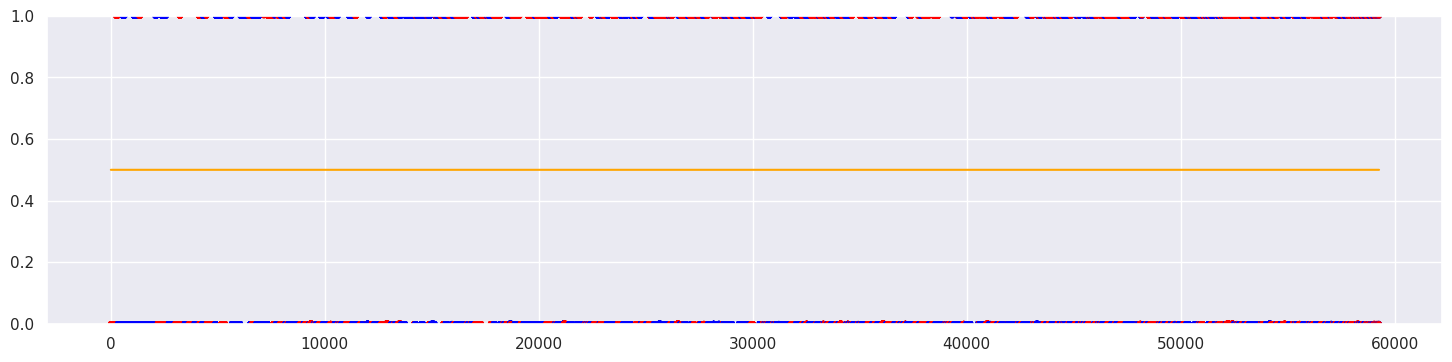

<Figure size 640x480 with 0 Axes>

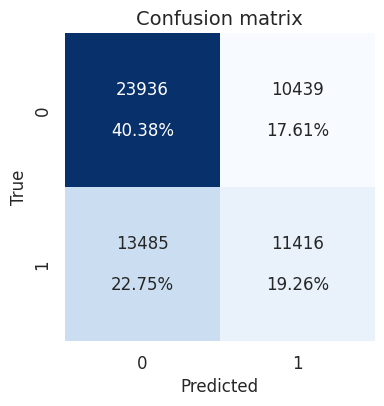

In [207]:
# prediction_and_metrics(model2, [test_tweets_text_data_tensor, test_tweets_add_feat_data_tensor, test_users_X_tensor], test_users_Y)
prediction_and_metrics(model4, [test_tweets_add_feat_data_tensor, test_users_X_tensor], test_users_Y)

Accuracy: 0.7041095890410959
Precision: [0.73136646 0.68259804]
Recall: 0.763013698630137
F1 score: 0.720569
ROC AUC: 0.704110


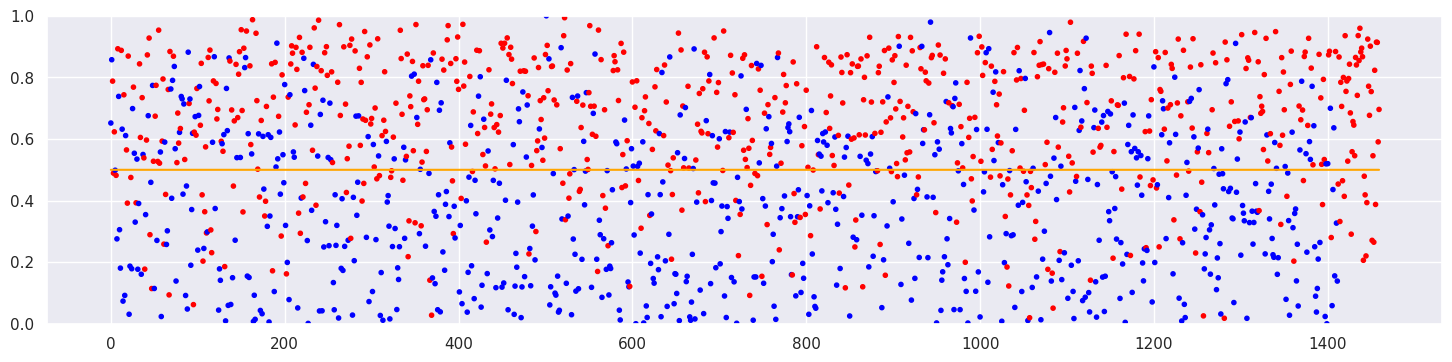

<Figure size 640x480 with 0 Axes>

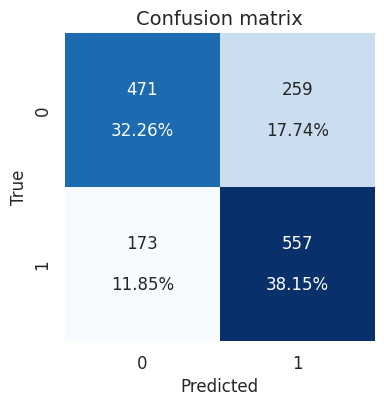

In [168]:
# prediction_and_metrics(model1, [test_tweets_text_data_tensor, test_tweets_add_feat_data_tensor, test_users_X_tensor], test_users_Y)